In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
import random

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Collection

In [2]:
# Loading Training Data
traincsv=pd.read_csv('train.csv')
train=pd.DataFrame(traincsv)
train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour    ...     Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl    ...                0         0     NaN   NaN   
1       IR1          Lvl    ...                0         0     NaN   NaN   
2       Reg          Lvl    ...                0         0     NaN   NaN   
3       Reg          Lvl    ...                0         0     NaN   NaN   
4       IR1          Lvl    ...                0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [3]:
# Loading Test Data
testcsv=pd.read_csv('test.csv')
test=pd.DataFrame(testcsv)
test.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour    ...     3Ssn Porch Screen Porch Pool Area  \
0  Grvl       Reg          Lvl    ...              0            0         0   
1   NaN       IR1          Lvl    ...              0            0         0   
2   NaN       IR1          Lvl    ...              0            0         0   
3   NaN       Reg          Lvl    ...              0            0         0   
4   NaN       IR1          Lvl    ...              0          185         0   

  Pool QC Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0     NaN   NaN          NaN        0       4     2006        WD   
1     NaN   NaN          NaN        0       8     2006        WD   
2     NaN   NaN          NaN        0       9     2006        New  
3     NaN   NaN          NaN        0       7     2007        WD   
4     NaN   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

#### Saving data. Data is immutable

In [4]:
train_original=train
test_original=test
train_original.to_csv('train_original.csv')
test_original.to_csv('test_original.csv')

## Data Profile

#### Data Dimension

In [5]:
tr_shp=train.shape
ts_shp=test.shape
shapedf=pd.DataFrame([("Training", tr_shp[0], tr_shp[1]),("Test", ts_shp[0], ts_shp[1])], 
              columns=["datasets", "rows", "columns"])
shapedf

datasets  rows  columns
0  Training  2051       81
1      Test   879       80

#### Data Types

In [6]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

Based on above information identified data types are 

- float64 
- int64 
- object

Deep Memory usage is around 5.4 MB

In [7]:
# Function to summerize datatypes
def dtype_report(df):
    int_eger=0
    obj_ect=0
    flo_at=0
    for i in train.select_dtypes('int'):
        int_eger+=1
    for i in train.select_dtypes('float'):
        flo_at+=1
    for i in train.select_dtypes('object'):
        obj_ect+=1
    dtype_rep=pd.DataFrame()
    dtype_rep['integer']=np.array([int_eger])
    dtype_rep['float']=np.array([flo_at])
    dtype_rep['object']=np.array([obj_ect])
    return dtype_rep
    

In [8]:
dtype_report(train)


integer  float  object
0       28     11      42

In [9]:
dtype_report(test)

integer  float  object
0       28     11      42

#### Missing Values

In [10]:
# Function to create missing report 
def missing_profile(df):
    missingdf_trn=pd.DataFrame(df.isnull().sum(), columns=['TotalMissing'])
    missingdf_trn=missingdf_trn[missingdf_trn['TotalMissing'] !=0]
    pct=lambda x:100*(x/shapedf.iloc[0,1])
    types=[df[i].dtype.name for i in missingdf_trn.index ]
    missingdf_trn["PercentMissing"]=missingdf_trn['TotalMissing'].map(pct)
    missingdf_trn["dataTypes"]=types
    return missingdf_trn

missing_profile(train).sort_values(by='PercentMissing', ascending=False) # Training data 
 

TotalMissing  PercentMissing dataTypes
Pool QC                 2042       99.561190    object
Misc Feature            1986       96.830814    object
Alley                   1911       93.174061    object
Fence                   1651       80.497318    object
Fireplace Qu            1000       48.756704    object
Lot Frontage             330       16.089712   float64
Garage Yr Blt            114        5.558264   float64
Garage Cond              114        5.558264    object
Garage Qual              114        5.558264    object
Garage Finish            114        5.558264    object
Garage Type              113        5.509508    object
Bsmt Exposure             58        2.827889    object
BsmtFin Type 2            56        2.730375    object
Bsmt Cond                 55        2.681619    object
Bsmt Qual                 55        2.681619    object
BsmtFin Type 1            55        2.681619    object
Mas Vnr Area              22        1.072647   float64
Mas Vnr Type              22        1.072647    object
Bsmt Half Bath             2        0.097513   float64
Bsmt Full Bath             2        0.097513   float64
Total Bsmt SF              1        0.048757   float64
Bsmt Unf SF                1        0.048757   float64
BsmtFin SF 2               1        0.048757   float64
Garage Cars                1        0.048757   float64
Garage Area                1        0.048757   float64
BsmtFin SF 1               1        0.048757   float64

In [11]:
missing_profile(test).sort_values(by='PercentMissing', ascending=False) # Training data 

TotalMissing  PercentMissing dataTypes
Pool QC                  875       42.662116    object
Misc Feature             838       40.858118    object
Alley                    821       40.029254    object
Fence                    707       34.470990    object
Fireplace Qu             422       20.575329    object
Lot Frontage             160        7.801073   float64
Garage Yr Blt             45        2.194052   float64
Garage Finish             45        2.194052    object
Garage Qual               45        2.194052    object
Garage Cond               45        2.194052    object
Garage Type               44        2.145295    object
Bsmt Exposure             25        1.218918    object
BsmtFin Type 1            25        1.218918    object
BsmtFin Type 2            25        1.218918    object
Bsmt Cond                 25        1.218918    object
Bsmt Qual                 25        1.218918    object
Mas Vnr Area               1        0.048757   float64
Mas Vnr Type               1        0.048757    object
Electrical                 1        0.048757    object

###### Training set and test set shows similar pattern in number of missing values. Most columns has few missing values and Few columns has most missing values

##### Dealing with missing value will be different for numerical and categorical value
##### Training data:

In [12]:
def print_plot_miss_report(df):
    miss_prof=missing_profile(df)
    miss_profdf=pd.DataFrame()
    miss_profdf['column_name']=miss_prof.index
    miss_profdf['percentMissing']=miss_prof['PercentMissing'].values
    miss_profdf['dataTypes']=miss_prof['dataTypes'].values
    
    miss_prof_gb=miss_profdf.groupby('dataTypes')
    for i in miss_profdf.dataTypes.unique():
        print(miss_prof_gb.get_group(i))
        plt.figure(figsize=(40, 38))
        miss_prof_gb.get_group(i).plot.barh(x='column_name', y='percentMissing')
        title="Missing values for data type "+i
        plt.title(title)
        plt.show()
        print('_______________________________')
        print('                               ')

       column_name  percentMissing dataTypes
0     Lot Frontage       16.089712   float64
3     Mas Vnr Area        1.072647   float64
8     BsmtFin SF 1        0.048757   float64
10    BsmtFin SF 2        0.048757   float64
11     Bsmt Unf SF        0.048757   float64
12   Total Bsmt SF        0.048757   float64
13  Bsmt Full Bath        0.097513   float64
14  Bsmt Half Bath        0.097513   float64
17   Garage Yr Blt        5.558264   float64
19     Garage Cars        0.048757   float64
20     Garage Area        0.048757   float64


<Figure size 2880x2736 with 0 Axes>

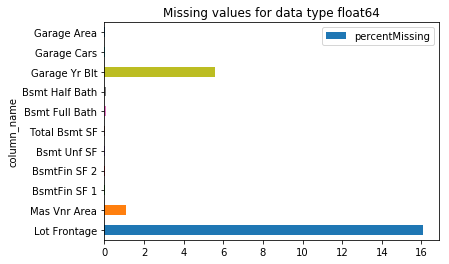

_______________________________
                               
       column_name  percentMissing dataTypes
1            Alley       93.174061    object
2     Mas Vnr Type        1.072647    object
4        Bsmt Qual        2.681619    object
5        Bsmt Cond        2.681619    object
6    Bsmt Exposure        2.827889    object
7   BsmtFin Type 1        2.681619    object
9   BsmtFin Type 2        2.730375    object
15    Fireplace Qu       48.756704    object
16     Garage Type        5.509508    object
18   Garage Finish        5.558264    object
21     Garage Qual        5.558264    object
22     Garage Cond        5.558264    object
23         Pool QC       99.561190    object
24           Fence       80.497318    object
25    Misc Feature       96.830814    object


<Figure size 2880x2736 with 0 Axes>

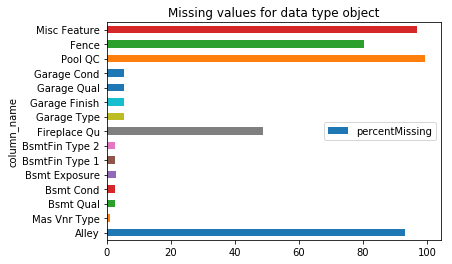

_______________________________
                               


In [13]:
print_plot_miss_report(train)
    

      column_name  percentMissing dataTypes
0    Lot Frontage        7.801073   float64
3    Mas Vnr Area        0.048757   float64
12  Garage Yr Blt        2.194052   float64


<Figure size 2880x2736 with 0 Axes>

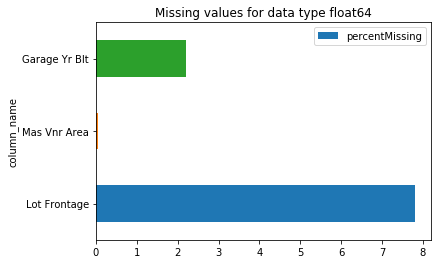

_______________________________
                               
       column_name  percentMissing dataTypes
1            Alley       40.029254    object
2     Mas Vnr Type        0.048757    object
4        Bsmt Qual        1.218918    object
5        Bsmt Cond        1.218918    object
6    Bsmt Exposure        1.218918    object
7   BsmtFin Type 1        1.218918    object
8   BsmtFin Type 2        1.218918    object
9       Electrical        0.048757    object
10    Fireplace Qu       20.575329    object
11     Garage Type        2.145295    object
13   Garage Finish        2.194052    object
14     Garage Qual        2.194052    object
15     Garage Cond        2.194052    object
16         Pool QC       42.662116    object
17           Fence       34.470990    object
18    Misc Feature       40.858118    object


<Figure size 2880x2736 with 0 Axes>

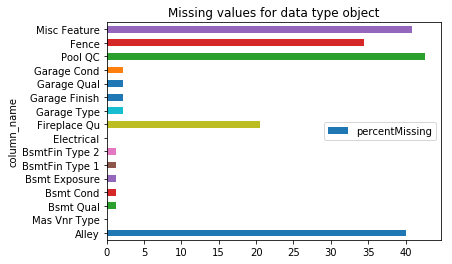

_______________________________
                               


In [14]:
print_plot_miss_report(test)

##### Tables and visualization shows most of the missing data are in categorical variables



##### We see very similar pattern of missing data. in test set as in training set Tables and visualization shows most of the missing data are in categorical variables. It has only 3 missing numerical columns

### Unique Values

In [15]:
# We will identify unique values of categorical variable to get an idea if they are oridinal 
def unq_val(df):
    obj_columns=[i for i in df.columns if df[i].dtypes=='object']
    for i in obj_columns:
        print('----- '+i+' ------------')
        print(df[i].unique())
unq_val(train) # Training data

----- MS Zoning ------------
['RL' 'RM' 'FV' 'C (all)' 'A (agr)' 'RH' 'I (all)']
----- Street ------------
['Pave' 'Grvl']
----- Alley ------------
[nan 'Pave' 'Grvl']
----- Lot Shape ------------
['IR1' 'Reg' 'IR2' 'IR3']
----- Land Contour ------------
['Lvl' 'HLS' 'Bnk' 'Low']
----- Utilities ------------
['AllPub' 'NoSeWa' 'NoSewr']
----- Lot Config ------------
['CulDSac' 'Inside' 'Corner' 'FR2' 'FR3']
----- Land Slope ------------
['Gtl' 'Sev' 'Mod']
----- Neighborhood ------------
['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'NridgHt' 'Gilbert' 'Crawfor'
 'IDOTRR' 'NWAmes' 'Veenker' 'MeadowV' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
----- Condition 1 ------------
['RRAe' 'Norm' 'PosA' 'Artery' 'Feedr' 'PosN' 'RRAn' 'RRNe' 'RRNn']
----- Condition 2 ------------
['Norm' 'RRNn' 'Feedr' 'Artery' 'PosA' 'PosN' 'RRAe' 'RRAn']
----- Bldg Type ------------
['1Fam' 'Twn

In [16]:
unq_val(test) # Test data

----- MS Zoning ------------
['RM' 'RL' 'FV' 'RH' 'C (all)' 'I (all)']
----- Street ------------
['Pave' 'Grvl']
----- Alley ------------
['Grvl' nan 'Pave']
----- Lot Shape ------------
['Reg' 'IR1' 'IR3' 'IR2']
----- Land Contour ------------
['Lvl' 'Bnk' 'Low' 'HLS']
----- Utilities ------------
['AllPub' 'NoSewr']
----- Lot Config ------------
['Inside' 'CulDSac' 'Corner' 'FR2' 'FR3']
----- Land Slope ------------
['Gtl' 'Mod' 'Sev']
----- Neighborhood ------------
['OldTown' 'Sawyer' 'Gilbert' 'NAmes' 'MeadowV' 'CollgCr' 'Somerst'
 'Mitchel' 'SawyerW' 'IDOTRR' 'BrkSide' 'Edwards' 'ClearCr' 'NWAmes'
 'Timber' 'NoRidge' 'NridgHt' 'Crawfor' 'StoneBr' 'Veenker' 'BrDale'
 'SWISU' 'Blmngtn' 'NPkVill' 'Greens' 'Blueste']
----- Condition 1 ------------
['Norm' 'Feedr' 'Artery' 'PosA' 'RRAn' 'PosN' 'RRNn' 'RRAe' 'RRNe']
----- Condition 2 ------------
['Norm' 'PosN' 'Feedr' 'PosA']
----- Bldg Type ------------
['2fmCon' 'Duplex' '1Fam' 'TwnhsE' 'Twnhs']
----- House Style ------------
['2Sto

##### Visualizing categorical variables. 

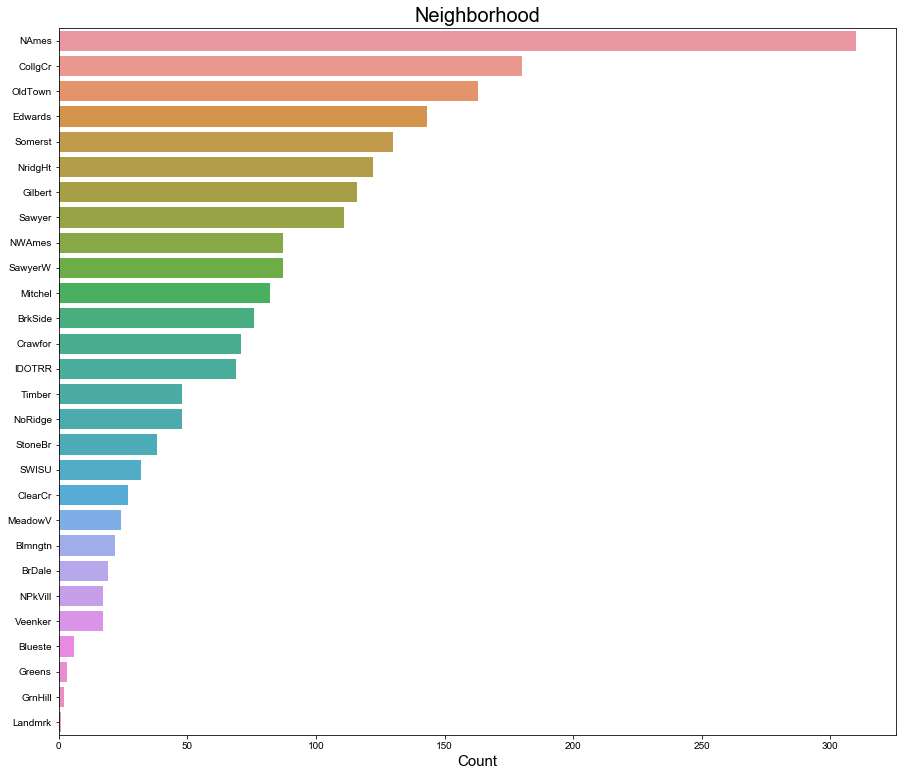

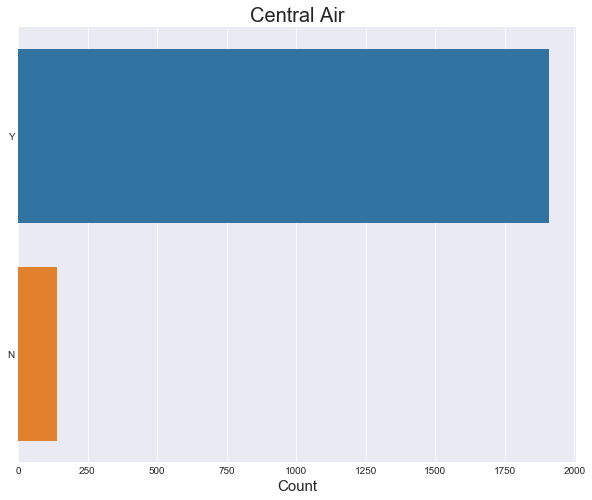

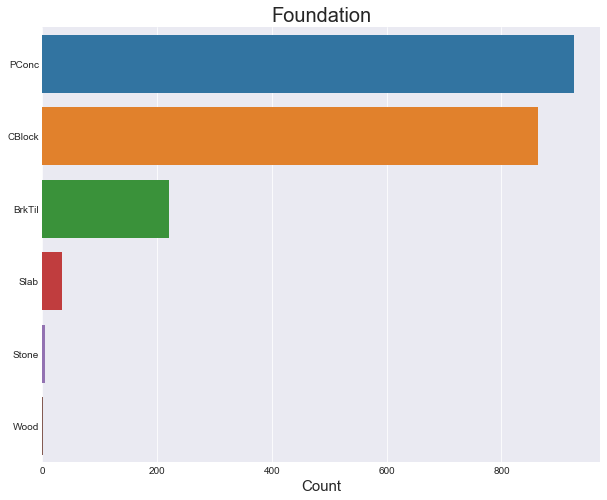

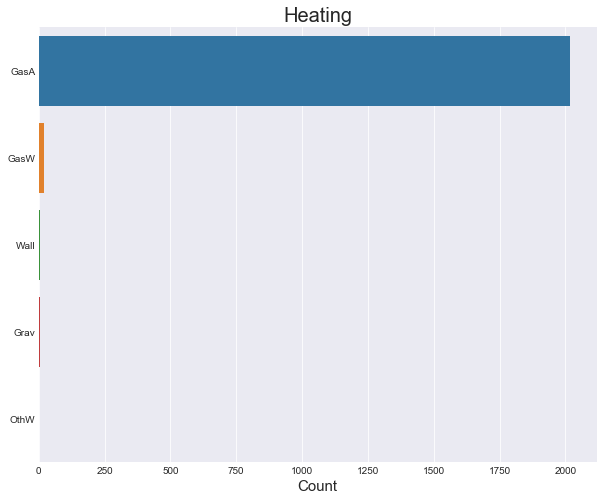

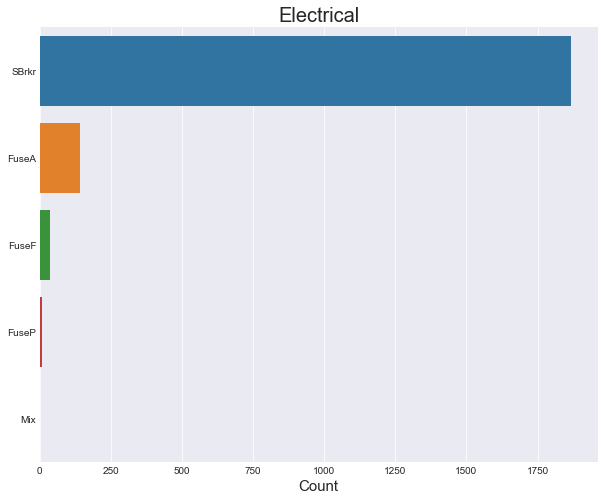

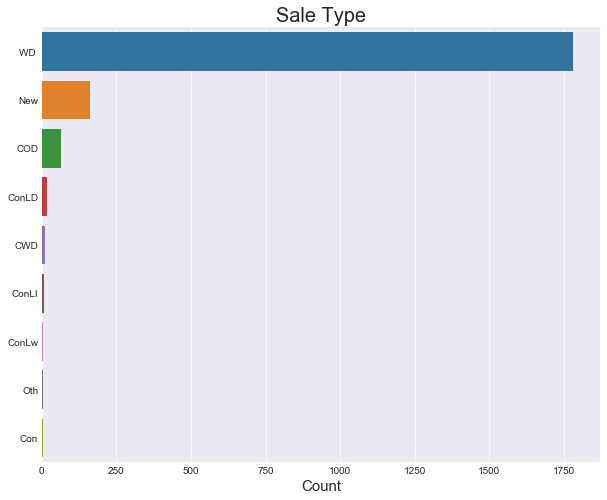

In [17]:
def visualize_count(df, col, size=(10,8)):
    
    fig=plt.figure(figsize=size)
    ax=fig.gca()
    sns.set_style("darkgrid")
    sns.barplot(x=df[col], y=df.index)
    ax.set_xlabel("Count", fontsize=15)
    plt.title(col, fontsize=20)
    
df_nbr=pd.DataFrame(train['Neighborhood'].value_counts()) # Neighborhood
df_ca=pd.DataFrame(train['Central Air'].value_counts()) # Central Air
df_fd=pd.DataFrame(train['Foundation'].value_counts()) # Foundation
df_ht=pd.DataFrame(train['Heating'].value_counts()) # Heating
df_el=pd.DataFrame(train['Electrical'].value_counts()) # Electrical
df_st=pd.DataFrame(train['Sale Type'].value_counts()) # Sale Type

visualize_count(df=df_nbr, col='Neighborhood', size=(15, 13))
visualize_count(df=df_ca, col='Central Air')
visualize_count(df=df_fd, col='Foundation')
visualize_count(df=df_ht, col='Heating')
visualize_count(df=df_el, col='Electrical')
visualize_count(df=df_st, col='Sale Type')



### Data statistics

In [18]:
train.drop(['Id', 'PID'],axis='columns', inplace=True)
def dtstats(df, numerical=True):
    # this is top print statistic of data frame based on numerical and 
    #categorical value. Default=numerical
    if numerical:
        col=[i for i in df.columns if df[i].dtype!=object]    
    else:
        col=[i for i in df.columns if df[i].dtype==object]
    return df[col].describe().T
        
print(dtstats(train))

                  count           mean           std      min       25%  \
MS SubClass      2051.0      57.008776     42.824223     20.0      20.0   
Lot Frontage     1721.0      69.055200     23.260653     21.0      58.0   
Lot Area         2051.0   10065.208191   6742.488909   1300.0    7500.0   
Overall Qual     2051.0       6.112140      1.426271      1.0       5.0   
Overall Cond     2051.0       5.562165      1.104497      1.0       5.0   
Year Built       2051.0    1971.708922     30.177889   1872.0    1953.5   
Year Remod/Add   2051.0    1984.190151     21.036250   1950.0    1964.5   
Mas Vnr Area     2029.0      99.695909    174.963129      0.0       0.0   
BsmtFin SF 1     2050.0     442.300488    461.204124      0.0       0.0   
BsmtFin SF 2     2050.0      47.959024    165.000901      0.0       0.0   
Bsmt Unf SF      2050.0     567.728293    444.954786      0.0     220.0   
Total Bsmt SF    2050.0    1057.987805    449.410704      0.0     793.0   
1st Flr SF       2051.0  

# Data Cleaning
### Removing space from column names

In [19]:
def removeColmnSapce(df):
    coldict={}
    for i in df.columns:
        coldict[i]=i.replace(' ', '')
    return df.rename(columns=coldict)
train=removeColmnSapce(train)
test=removeColmnSapce(test)

In [20]:
train.head(4)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL          NaN    13517   Pave   NaN      IR1   
1          60       RL         43.0    11492   Pave   NaN      IR1   
2          20       RL         68.0     7922   Pave   NaN      Reg   
3          60       RL         73.0     9802   Pave   NaN      Reg   

  LandContour Utilities LotConfig    ...     ScreenPorch PoolArea PoolQC  \
0         Lvl    AllPub   CulDSac    ...               0        0    NaN   
1         Lvl    AllPub   CulDSac    ...               0        0    NaN   
2         Lvl    AllPub    Inside    ...               0        0    NaN   
3         Lvl    AllPub    Inside    ...               0        0    NaN   

  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SalePrice  
0   NaN         NaN       0       3    2010       WD      130500  
1   NaN         NaN       0       4    2009       WD      220000  
2   NaN         NaN       0       1    2010       WD      109000  
3   NaN         NaN       0       4    2010       WD      174000  

[4 rows x 79 columns]

In [21]:
test.head(4)

Id        PID  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0  2658  902301120         190       RM         69.0     9142   Pave  Grvl   
1  2718  905108090          90       RL          NaN     9662   Pave   NaN   
2  2414  528218130          60       RL         58.0    17104   Pave   NaN   
3  1989  902207150          30       RM         60.0     8520   Pave   NaN   

  LotShape LandContour    ...    3SsnPorch ScreenPorch PoolArea PoolQC Fence  \
0      Reg         Lvl    ...            0           0        0    NaN   NaN   
1      IR1         Lvl    ...            0           0        0    NaN   NaN   
2      IR1         Lvl    ...            0           0        0    NaN   NaN   
3      Reg         Lvl    ...            0           0        0    NaN   NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  
0         NaN       0      4    2006       WD   
1         NaN       0      8    2006       WD   
2         NaN       0      9    2006       New  
3         NaN       0      7    2007       WD   

[4 rows x 80 columns]

### Handling missing data

##### Handling missing  value from training data
#### ***Strategies based on data profile: ****

1) ```LotFrontage``` has the most number of missing values among numerical variables(16.08%). Missing values will be imputed using Linear Regression

2)```Mas Vnr Area ``` and ```Mas Vnr Type``` has same number of missing values we will assume there is no ```Mas Vnr Area ``` for missing type and will be replaced with 0

3)```Garage Yr Blt``` has around 5% missing values needs more investigation.

4) Other numerical variable less than 1% missing values will be imputed with mean values

5) Train and test will follow same strategies 

6) Categorical variable will be replaced with ```'0'```

7) ```Alley, Pool QC, Misc Feature, Fence ``` over 80% data are missing so will drop those column
##### Training data

In [22]:
areadf=train[['LotFrontage', 'LotArea']]
areadf.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
areadfy=areadf[['LotFrontage']]
areadfx=areadf[['LotArea']]

In [24]:
areadfy.shape

(1721, 1)

In [25]:
lr=LinearRegression()
lr.fit(areadfx, areadfy)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# Linear Regression param
print(f"Coefficient {lr.coef_}")
print(f"Intercept {lr.intercept_}")
print(f"Correlation {areadf['LotFrontage'].corr(areadf['LotArea'])}")

Coefficient [[0.00267326]]
Intercept [43.33160739]
Correlation 0.574024317117997


#### To avoid underestimating the variance we will add random error

In [27]:
# Random Errors
rand_error=np.linspace(-100, 100, 1000)

In [28]:
# function to impute with Linear Regression
def impute_withlr(df, coef, col, inter, random_error_list):
    x=df[col].map(lambda x: x*coef + inter + random.choice(random_error_list))
    return list(x)[0][0][0]

In [29]:
train['LotFrontage'].fillna(impute_withlr(train, lr.coef_, 'LotArea',lr.intercept_, rand_error), inplace=True)

In [30]:
test['LotFrontage'].fillna(impute_withlr(test, lr.coef_, 'LotArea',lr.intercept_, rand_error),  inplace=True)

#### Garage Yr Blt has around 5% missing values . Investigating..

In [31]:
garage_tr=train[train['GarageYrBlt'].isnull()][['GarageYrBlt', 'GarageArea']]
garage_tr.head()

GarageYrBlt  GarageArea
28           NaN         0.0
53           NaN         0.0
65           NaN         0.0
79           NaN         0.0
101          NaN         0.0

In [32]:
# Seems like  missing value of GarageYrBlt has GarageArea=0
# Confirming if there are any missing value of GarageYrBlt has GarageArea more than zero
# Training Data
garage_tr[(garage_tr['GarageArea']>0) | (garage_tr['GarageArea'].isnull())]

GarageYrBlt  GarageArea
1712          NaN         NaN

In [33]:
# Doing the same for test data
garage_ts=test[test['GarageYrBlt'].isnull()][['GarageYrBlt', 'GarageArea']]
garage_ts[(garage_ts['GarageArea']>0) | (garage_ts['GarageArea'].isnull())]

GarageYrBlt  GarageArea
765          NaN       360.0

#### We see anomaly in both Train and Test data set 

In [34]:
# We will drop the above row and replace othe missing values of GarageYrBlt with 0
train.drop(train.index[1712], inplace=True)
test.drop(test.index[785], inplace=True)

In [35]:
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)

#### Removing missing values for ```MasVnrArea```

In [36]:
train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)


#### Basement : 
 Data contains 3 type of basement Type 1, Type 2 and Type 3. Due to lack of domain knowledge 
 I took information from https://budgetdry.com/3-types-of-basement-finishing/

**Finished Basement**

A basement that is completely constructed is termed as a finished basement. A finished basement is completely habitable. You can use it as a living room or a recreational room. You can also convert it into a game room, an office, a media room, a gym, and so on. It is a good idea to consider your, and your family’s needs, before finishing a basement. This will help you to use your basement space practically. For example, you may divide the basement area into two sections, one to act as a media room, the other, as a kid’s play area. All the finished basements do not require a complete redesign. For example, you can just put a sectional couch in the basement to divide the basement area. Fresh paint, new rugs, and good lighting fixtures will help to make your basement look good and new.

**Unfinished Basement**

Unfinished basements are common in homes throughout the United States. You will be able to find the following in an unfinished basement.

Water heater
A workbench
A number of pipes running along the ceiling, and downwards to the floor
A refrigerator or a freezer
A dryer / washer
Boxes of items not required in the house
An unfinished basement is typically used to store old household items. It can be an ideal place to set up your workshop. You don’t have to worry about the metal chips or sawdust or any other material cluttering your floor. Unfinished basements and mostly functional in purpose.

**Partially Finished Basement***

A partially finished basement is also called as a half-finished basement. It is mostly used by children and teenagers. It can be used as a work area for the entire family. You may also be able to find showers and toilets in this type of basement. The main difference between a partially finished basement and a finished and unfinished basement is that it is entirely unmodified. You may find furniture, gym equipment or recreational appliances in a partially finished basement.

In [37]:
train['TotalBsmtSF'].fillna(0, inplace=True)
test['TotalBsmtSF'].fillna(0, inplace=True)

In [38]:
# Creating data frame of Lot area and basement square foot
bsmtdf=train[['BsmtFullBath', 'BsmtHalfBath', '1stFlrSF', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'LotArea', 'TotalBsmtSF' ]]
bsmtdf.dropna(inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# Corelation with 1st floor sq foot
print(f"Pearson corelation BsmtFinSF1: {bsmtdf['BsmtFinSF1'].corr(bsmtdf['1stFlrSF'])}")
print(f"Pearson corelation BsmtFinSF2: {bsmtdf['BsmtFinSF2'].corr(bsmtdf['1stFlrSF'])}")
print(f"Pearson corelation BsmtUnfSF: {bsmtdf['BsmtUnfSF'].corr(bsmtdf['1stFlrSF'])}")
print(f"Pearson corelation BsmtFullBath: {bsmtdf['BsmtFullBath'].corr(bsmtdf['1stFlrSF'])}")
print(f"Pearson corelation BsmtHalfBath: {bsmtdf['BsmtHalfBath'].corr(bsmtdf['1stFlrSF'])}")

Pearson corelation BsmtFinSF1: 0.4707260432161863
Pearson corelation BsmtFinSF2: 0.09763260982295914
Pearson corelation BsmtUnfSF: 0.3098966359823369
Pearson corelation BsmtFullBath: 0.26937476937983346
Pearson corelation BsmtHalfBath: 0.00862605817666572


In [40]:
# Corelation with Lot Area
print(f"Pearson corelation BsmtFinSF1: {bsmtdf['BsmtFinSF1'].corr(bsmtdf['LotArea'])}")
print(f"Pearson corelation BsmtFinSF2: {bsmtdf['BsmtFinSF2'].corr(bsmtdf['LotArea'])}")
print(f"Pearson corelation BsmtUnfSF: {bsmtdf['BsmtUnfSF'].corr(bsmtdf['LotArea'])}")
print(f"Pearson corelation BsmtFullBath: {bsmtdf['BsmtFullBath'].corr(bsmtdf['LotArea'])}")
print(f"Pearson corelation BsmtHalfBath: {bsmtdf['BsmtHalfBath'].corr(bsmtdf['LotArea'])}")

Pearson corelation BsmtFinSF1: 0.2196797608953143
Pearson corelation BsmtFinSF2: 0.042790132749110775
Pearson corelation BsmtUnfSF: 0.04490693375316251
Pearson corelation BsmtFullBath: 0.11608836287141493
Pearson corelation BsmtHalfBath: 0.029962615799531044


In [41]:
# Corelation with Total Basement Sq Foot
print(f"Pearson corelation BsmtFinSF1: {bsmtdf['BsmtFinSF1'].corr(bsmtdf['TotalBsmtSF'])}")
print(f"Pearson corelation BsmtFinSF2: {bsmtdf['BsmtFinSF2'].corr(bsmtdf['TotalBsmtSF'])}")
print(f"Pearson corelation BsmtUnfSF: {bsmtdf['BsmtUnfSF'].corr(bsmtdf['TotalBsmtSF'])}")
print(f"Pearson corelation BsmtFullBath: {bsmtdf['BsmtFullBath'].corr(bsmtdf['TotalBsmtSF'])}")
print(f"Pearson corelation BsmtHalfBath: {bsmtdf['BsmtHalfBath'].corr(bsmtdf['TotalBsmtSF'])}")

Pearson corelation BsmtFinSF1: 0.5388295195627985
Pearson corelation BsmtFinSF2: 0.08627212540392999
Pearson corelation BsmtUnfSF: 0.41843339843270444
Pearson corelation BsmtFullBath: 0.3212629111881855
Pearson corelation BsmtHalfBath: 0.005349262968438099


#### Basement finished square foot & Basement unfinished square foot has more correlation with Total basement square foot 

In [42]:
bsmtdfy1=bsmtdf[['BsmtFinSF1']]
bsmtdfy2=bsmtdf[['BsmtUnfSF']]
bsmtdfx=bsmtdf[['TotalBsmtSF']]

In [43]:
lr1=LinearRegression()
lr1.fit(bsmtdfx, bsmtdfy1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
# Random error to avoid underestimating variance
rand_error_bsmnt=np.linspace(-10, 10, 100)

In [45]:
train['BsmtFinSF1'].fillna(impute_withlr(train, lr1.coef_, 'TotalBsmtSF',lr1.intercept_,rand_error_bsmnt), inplace=True)
test['BsmtFinSF1'].fillna(impute_withlr(test, lr1.coef_, 'TotalBsmtSF',lr1.intercept_,rand_error_bsmnt), inplace=True)

In [46]:
lr2=LinearRegression()
lr2.fit(bsmtdfx, bsmtdfy2)
train['BsmtUnfSF'].fillna(impute_withlr(train, lr2.coef_, '1stFlrSF',lr2.intercept_,rand_error_bsmnt), inplace=True)
test['BsmtUnfSF'].fillna(impute_withlr(test, lr2.coef_, '1stFlrSF',lr2.intercept_,rand_error_bsmnt), inplace=True)

In [47]:
# Unable to figure any correct way to fill basement full bath and Half bath so will fill missing valiues with zero

train['BsmtFullBath'].fillna(0, inplace=True)
test['BsmtFullBath'].fillna(0, inplace=True)
train['BsmtHalfBath'].fillna(0, inplace=True)
test['BsmtHalfBath'].fillna(0, inplace=True)
train['BsmtFinSF2'].fillna(0, inplace=True)
test['BsmtFinSF2'].fillna(0, inplace=True)

         columns dataTypes  pctMissings
0          Alley    object    93.125305
1     MasVnrType    object     1.072647
2       BsmtQual    object     2.681619
3       BsmtCond    object     2.681619
4   BsmtExposure    object     2.827889
5   BsmtFinType1    object     2.681619
6   BsmtFinType2    object     2.730375
7    FireplaceQu    object    48.707947
8     GarageType    object     5.509508
9   GarageFinish    object     5.509508
10    GarageQual    object     5.509508
11    GarageCond    object     5.509508
12        PoolQC    object    99.512433
13         Fence    object    80.497318
14   MiscFeature    object    96.782058


<Figure size 2880x2736 with 0 Axes>

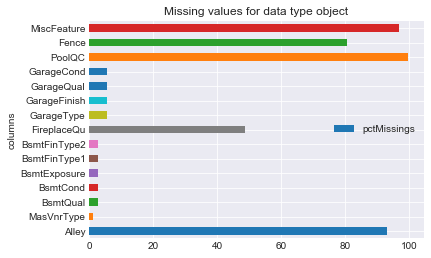

_______________________________
                               


In [48]:
missingdf_trn=pd.DataFrame(train.isnull().sum(), columns=['TotalMissing'])
missingdf_trn=missingdf_trn[missingdf_trn['TotalMissing'] !=0]
pct=lambda x:100*(x/shapedf.iloc[0,1])
missingdf_trn["PercentMissing"]=missingdf_trn['TotalMissing'].map(pct)
missingdf_trn.sort_values(by='PercentMissing', ascending=False)
types=[train[i].dtype.name for i in missingdf_trn.index ]
miss_prof=pd.DataFrame()
col=np.array(missingdf_trn.index)
types=np.array(types)
pct=np.array(missingdf_trn.PercentMissing.values)
miss_prof['columns']=col
miss_prof['dataTypes']=types
miss_prof['pctMissings']=pct
                        
#miss_prof
miss_prof
miss_prof_gb=miss_prof.groupby('dataTypes')
for i in miss_prof.dataTypes.unique():
    print(miss_prof_gb.get_group(i))
    plt.figure(figsize=(40, 38))
    miss_prof_gb.get_group(i).plot.barh(x='columns', y='pctMissings')
    title="Missing values for data type "+i
    plt.title(title)
    plt.show()
    print('_______________________________')
    print('                               ')
    
    

         columns dataTypes  pctMissings
0          Alley    object    39.980497
1     MasVnrType    object     0.048757
2       BsmtQual    object     1.218918
3       BsmtCond    object     1.218918
4   BsmtExposure    object     1.218918
5   BsmtFinType1    object     1.218918
6   BsmtFinType2    object     1.218918
7     Electrical    object     0.048757
8    FireplaceQu    object    20.526572
9     GarageType    object     2.145295
10  GarageFinish    object     2.194052
11    GarageQual    object     2.194052
12    GarageCond    object     2.194052
13        PoolQC    object    42.613359
14         Fence    object    34.470990
15   MiscFeature    object    40.809361


<Figure size 2880x2736 with 0 Axes>

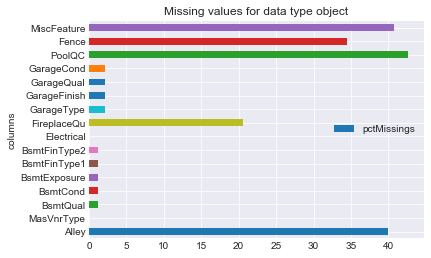

_______________________________
                               


In [49]:
missingdf_trn=pd.DataFrame(test.isnull().sum(), columns=['TotalMissing'])
missingdf_trn=missingdf_trn[missingdf_trn['TotalMissing'] !=0]
pct=lambda x:100*(x/shapedf.iloc[0,1])
missingdf_trn["PercentMissing"]=missingdf_trn['TotalMissing'].map(pct)
missingdf_trn.sort_values(by='PercentMissing', ascending=False)
types=[train[i].dtype.name for i in missingdf_trn.index ]
miss_prof=pd.DataFrame()
col=np.array(missingdf_trn.index)
types=np.array(types)
pct=np.array(missingdf_trn.PercentMissing.values)
miss_prof['columns']=col
miss_prof['dataTypes']=types
miss_prof['pctMissings']=pct
                        
#miss_prof
miss_prof
miss_prof_gb=miss_prof.groupby('dataTypes')
for i in miss_prof.dataTypes.unique():
    print(miss_prof_gb.get_group(i))
    plt.figure(figsize=(40, 38))
    miss_prof_gb.get_group(i).plot.barh(x='columns', y='pctMissings')
    title="Missing values for data type "+i
    plt.title(title)
    plt.show()
    print('_______________________________')
    print('                               ')
    
    

### GREAT !!! Got rid of all numerical missing value

### Handling categorical missing value

In [50]:
def testNotinTrain(df):
    '''To replace categorical variable we
       need to make sure the values match.
       This function identifies mismatch values'''
    mismatch={}
    obj_columns=[i for i in train.columns if train[i].dtypes=='object']
    for i in obj_columns:
        ms_match=[]
        test_l=[k for k in df[i].unique()]
        train_l=[k for k in train[i].unique()]
        ms_match=[j for j in test_l if j not in train_l]
        if ms_match:
            mismatch[i]=ms_match
            
    return mismatch
print(testNotinTrain(test))

{'RoofMatl': ['Metal', 'Roll'], 'Exterior1st': ['PreCast'], 'Exterior2nd': ['PreCast', 'Other'], 'MasVnrType': ['CBlock'], 'Heating': ['Floor'], 'Electrical': [nan], 'KitchenQual': ['Po'], 'SaleType': ['VWD']}


#### We will use information from data profile to replace mismatch values

In [51]:
test['RoofMatl']=test['RoofMatl'].replace('Metal', 'ClyTile')
test['Exterior2nd']=test['Exterior2nd'].replace('PreCast', 'CBlock')
test['Exterior2nd']=test['Exterior2nd'].replace('Other', 'CBlock')
test['RoofMatl']=test['RoofMatl'].replace('Roll', 'Membran')
test['Exterior1st']=test['Exterior1st'].replace('PreCast', 'CBlock')
test['MasVnrType']=test['MasVnrType'].replace('CBlock','BrkCmn')
test['MasVnrType']=test['MasVnrType'].replace('0','BrkCmn')
test['Heating']=test['Heating'].replace('Floor', 'GasA')
test['Electrical']=test['Electrical'].replace('0','SBrkr')
test['KitchenQual']=test['KitchenQual'].replace('Po','Fa')
test['SaleType']=test['SaleType'].replace('VWD','WD ')

In [52]:
missing_profile(train).sort_values(by='dataTypes', ascending=False)

TotalMissing  PercentMissing dataTypes
Alley                 1910       93.125305    object
MasVnrType              22        1.072647    object
BsmtQual                55        2.681619    object
BsmtCond                55        2.681619    object
BsmtExposure            58        2.827889    object
BsmtFinType1            55        2.681619    object
BsmtFinType2            56        2.730375    object
FireplaceQu            999       48.707947    object
GarageType             113        5.509508    object
GarageFinish           113        5.509508    object
GarageQual             113        5.509508    object
GarageCond             113        5.509508    object
PoolQC                2041       99.512433    object
Fence                 1651       80.497318    object
MiscFeature           1985       96.782058    object

In [53]:
# All Categorical with  more than 80% missing values will be removed
train.drop(columns=['Alley','PoolQC', 'Fence', 'MiscFeature' ], inplace=True)
test.drop(columns=['Alley','PoolQC', 'Fence', 'MiscFeature' ], inplace=True)

#### Masonry veneer type

In [54]:
train['MasVnrType'].fillna('NA', inplace=True)
test['MasVnrType'].fillna('NA', inplace=True)

In [55]:
def impute_categQual(df, col1, col2, replc1, replc2):
    """Intake dataframe compare with numerical columns
    and replace bull value acordingly"""
    for i in df[df[col1].isnull()][col2]:
        
        if i>0:
            df[col1].fillna(replc1, inplace=True)
        elif i==0:
            df[col1].fillna(replc2, inplace=True)
    

In [56]:
impute_categQual(train,'GarageQual', 'GarageArea', 'TA', 'NA' )
impute_categQual(train,'GarageCond', 'GarageArea', 'TA', 'NA' )
impute_categQual(train,'BsmtQual', 'TotalBsmtSF', 'TA', 'NA' )
impute_categQual(train,'BsmtCond', 'TotalBsmtSF', 'TA', 'NA' )
impute_categQual(train,'BsmtExposure', 'TotalBsmtSF', 'MN', 'NA' )
impute_categQual(train,'BsmtFinType1', 'BsmtFinSF1', 'Rec', 'NA' )
impute_categQual(train,'BsmtFinType2', 'BsmtFinSF2', 'Rec', 'NA' )
impute_categQual(train,'FireplaceQu', 'Fireplaces', 'Rec', 'NA' )
impute_categQual(train,'GarageType', 'GarageArea', 'Attchd', 'NA' )
impute_categQual(train,'GarageFinish', 'GarageArea', 'Unf', 'NA' )

In [57]:
impute_categQual(test,'GarageQual', 'GarageArea', 'TA', 'NA' )
impute_categQual(test,'GarageCond', 'GarageArea', 'TA', 'NA' )
impute_categQual(test,'BsmtQual', 'TotalBsmtSF', 'TA', 'NA' )
impute_categQual(test,'BsmtCond', 'TotalBsmtSF', 'TA', 'NA' )
impute_categQual(test,'BsmtExposure', 'TotalBsmtSF', 'MN', 'NA' )
impute_categQual(test,'BsmtFinType1', 'BsmtFinSF1', 'Rec', 'NA' )
impute_categQual(test,'BsmtFinType2', 'BsmtFinSF2', 'Rec', 'NA' )
impute_categQual(test,'FireplaceQu', 'Fireplaces', 'Rec', 'NA' )
impute_categQual(test,'GarageType', 'GarageArea', 'Attchd', 'NA' )
impute_categQual(test,'GarageFinish', 'GarageArea', 'Unf', 'NA' )

### Imputing Home Electrical 

In [58]:
train['Electrical'].isnull().sum()

0

In [59]:
test['Electrical'].isnull().sum()

1

In [60]:
test[test['Electrical'].isnull()]['YearBuilt']

635    2006
Name: YearBuilt, dtype: int64

In [61]:
test[test['YearBuilt']==2006]['Electrical'].value_counts()

SBrkr    38
Name: Electrical, dtype: int64

In [62]:
train[train['YearBuilt']==2006]['Electrical'].value_counts()

SBrkr    99
Name: Electrical, dtype: int64

#### Test data has one row with ```Electrical``` missing all house nuilt in year 2006 has type ``SBrkr```

In [63]:
test['Electrical'].fillna('SBrkr', inplace=True)

In [64]:
missing_profile(train).sort_values(by='dataTypes', ascending=False)

Empty DataFrame
Columns: [TotalMissing, PercentMissing, dataTypes]
Index: []

In [65]:
missing_profile(test).sort_values(by='dataTypes', ascending=False)

Empty DataFrame
Columns: [TotalMissing, PercentMissing, dataTypes]
Index: []

In [66]:
test.to_csv('test_cleaned.csv')

## Exploratory Data Analysis & Feature Engineering

In [67]:
def grid_plot(df):
    grid=sns.pairplot(df, diag_kind='kde', palette='set-4' )
    grid.map_upper(plt.scatter, alpha = 0.2)
    grid.map_diag(sns.kdeplot)

    # Bottom is density plot
    grid.map_lower(sns.kdeplot, cmap = plt.cm.jet_r);

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


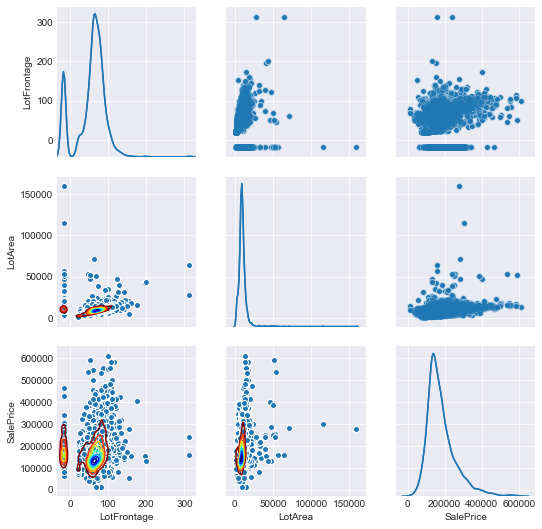

In [68]:
trainN_SF1=train[['LotFrontage','LotArea', 'SalePrice']]
grid_plot(trainN_SF1)

In [69]:
print(f"Pearson corelation with Lot Area: {train['SalePrice'].corr(train['LotArea'])}")

print(f"Pearson corelation with Lot Frontage: {train['SalePrice'].corr(train['LotFrontage'])}")



Pearson corelation with Lot Area: 0.2965501446056615
Pearson corelation with Lot Frontage: 0.15082812799269393


#### Lot area has higher correlation. We will use logarithmic scale to see if correlation improves

In [70]:
trainN_SF1_Log=pd.DataFrame()

trainN_SF1_Log['LotFrontage']=trainN_SF1['LotFrontage'].map(lambda x: np.log(x))
trainN_SF1_Log['LotArea']=trainN_SF1['LotArea'].map(lambda x: np.log(x))
trainN_SF1_Log['SalePrice']=trainN_SF1['SalePrice']
trainN_SF1_Log.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


LotFrontage   LotArea  SalePrice
0          NaN  9.511703     130500
1     3.761200  9.349406     220000
2     4.219508  8.977399     109000
3     4.290459  9.190342     174000
4     4.406719  9.563459     138500

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked ele

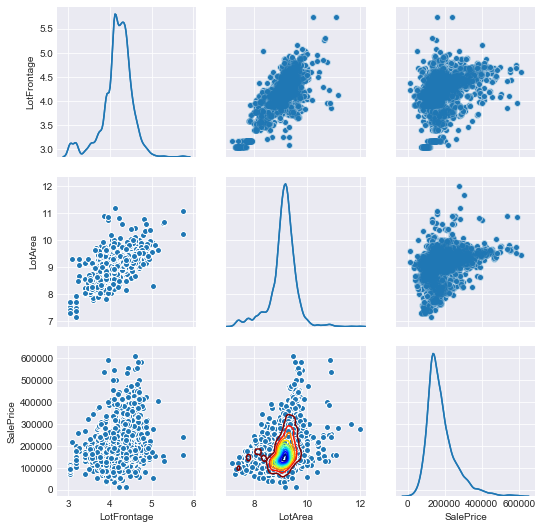

In [71]:
grid_plot(trainN_SF1_Log)

In [72]:
print(f"Pearson corelation with LotFrontage log: {trainN_SF1_Log['SalePrice'].corr(trainN_SF1_Log['LotFrontage'])}")
print(f"Pearson corelation with LotArea log: {trainN_SF1_Log['SalePrice'].corr(trainN_SF1_Log['LotArea'])}")

Pearson corelation with LotFrontage log: 0.3305936026856529
Pearson corelation with LotArea log: 0.36669808607507814


#### Logarithmic scale improves the correlation. Lot Area log is significant feature to be considered

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z

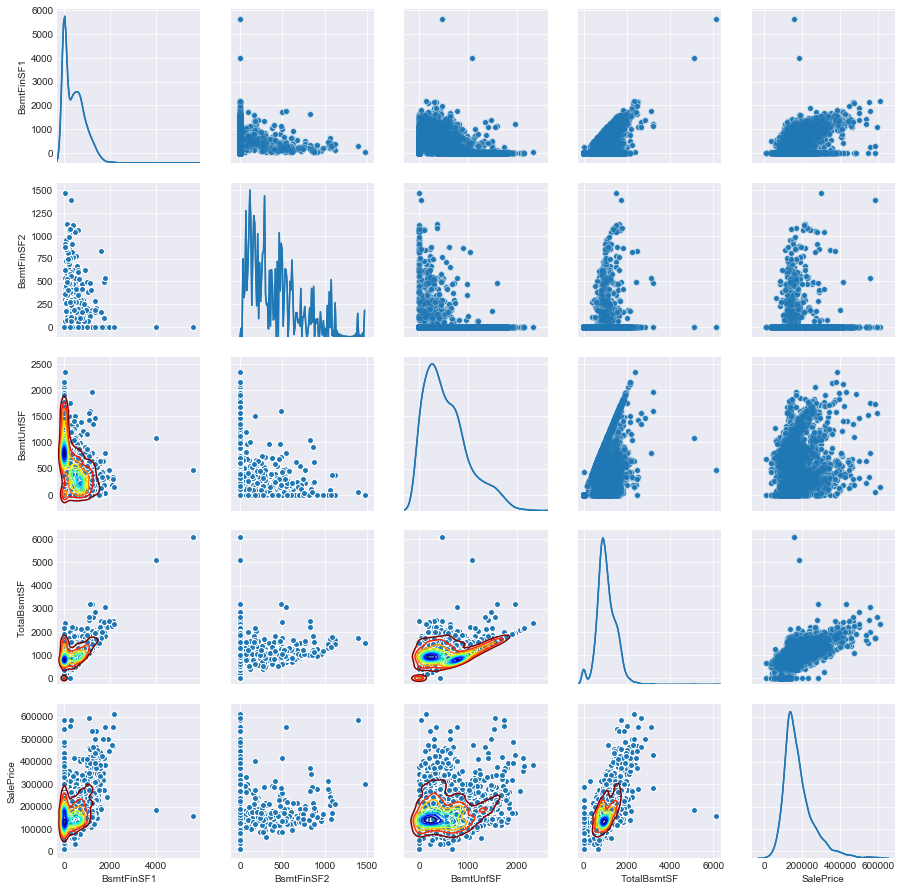

In [73]:
trainN_SF2=train[[ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',  'SalePrice']]
grid_plot(trainN_SF2)

#### Total basement area has strong correlation. Total Basement Area is strong feature. Will discard other basement area features to avoid multi-colinearity

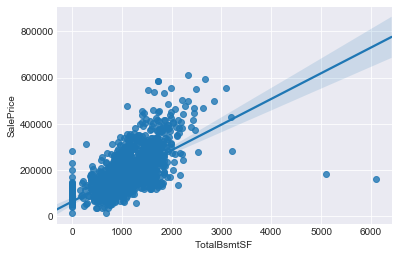

In [74]:
sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'])

While there is strong correlation we will see some outliers where values of home price is lower with more basement area. Trying to detect those outliers

In [75]:
train[train['TotalBsmtSF']>5000]

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
960           60       RL        313.0    63887   Pave      IR3         Bnk   
1885          20       RL        128.0    39290   Pave      IR1         Bnk   

     Utilities LotConfig LandSlope    ...    OpenPorchSF EnclosedPorch  \
960     AllPub    Corner       Gtl    ...            292             0   
1885    AllPub    Inside       Gtl    ...            484             0   

     3SsnPorch ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleType  \
960          0           0      480        0       1    2008       New   
1885         0           0        0    17000      10    2007       New   

     SalePrice  
960     160000  
1885    183850  

[2 rows x 75 columns]

In [76]:
train.shape

(2050, 75)

Dropping the outliers

In [77]:
train.drop([960, 1885], inplace=True)

In [78]:
train.shape

(2048, 75)

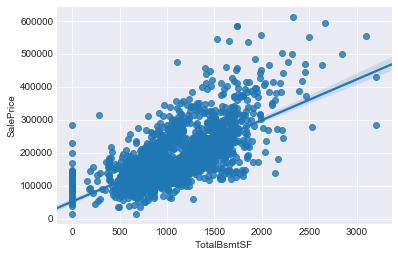

In [79]:
sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous]

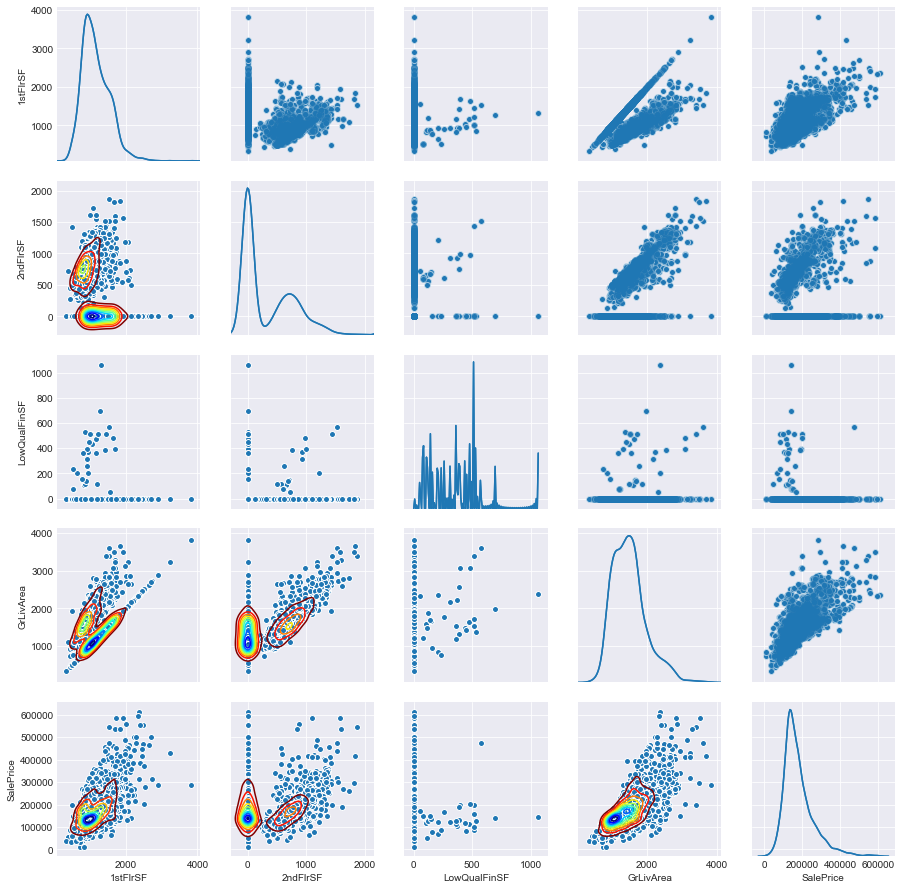

In [80]:
trainN_SF3=train[ ['1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'SalePrice']]
grid_plot(trainN_SF3)

Ground floor living area and 1stFlrSf shows strong correlation with sales price. However we also see potential of issue of multicolinearity if we include Ground floor living area and 1stFlrSf. So we will check Pearson' corealtion

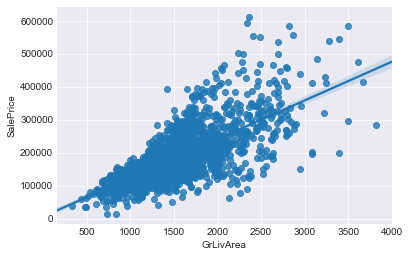

In [81]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

Seeing some outlier where area greater than 3000 has price less than 300000. We will identify those outliers and will discard them

In [82]:
train.loc[(train['GrLivArea']>3000) & (train['SalePrice']<300000)]

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
616           20       RL        123.0    47007   Pave      IR1         Lvl   
858          190       RH         60.0    10896   Pave      Reg         Bnk   
1433          75       RL        102.0    15863   Pave      Reg         Lvl   
1563          50       RL        138.0    18030   Pave      IR1         Bnk   
1939          75       RM         87.0    18386   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope    ...    OpenPorchSF EnclosedPorch  \
616     AllPub    Inside       Gtl    ...            372             0   
858     AllPub    Inside       Gtl    ...            110             0   
1433    AllPub    Corner       Gtl    ...             63             0   
1563    AllPub    Inside       Gtl    ...              0             0   
1939    AllPub    Inside       Gtl    ...              0             0   

     3SsnPorch ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleType  \
616          0           0        0        0       7    2008       WD    
858          0           0        0        0       3    2007       WD    
1433         0           0        0        0       8    2009       WD    
1563         0           0        0        0       3    2007       WD    
1939         0           0        0        0       5    2008       WD    

     SalePrice  
616     284700  
858     200000  
1433    197000  
1563    200500  
1939    295000  

[5 rows x 75 columns]

In [83]:
train.drop([616, 858,1433, 1563, 1939 ], inplace=True)

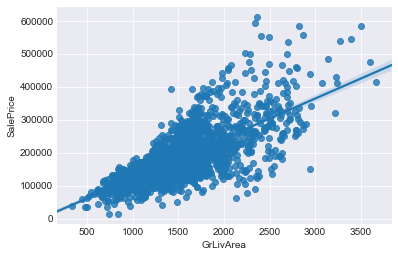

In [84]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

In [85]:
print(f"Pearson corelation with 1stFlrSF: {train['SalePrice'].corr(train['1stFlrSF'])}")
print(f"Pearson corelation with GrLivArea: {train['SalePrice'].corr(train['GrLivArea'])}")

Pearson corelation with 1stFlrSF: 0.6518914251272697
Pearson corelation with GrLivArea: 0.7270495410606467


#### Ground Living Area is an important feature over other area related feature

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


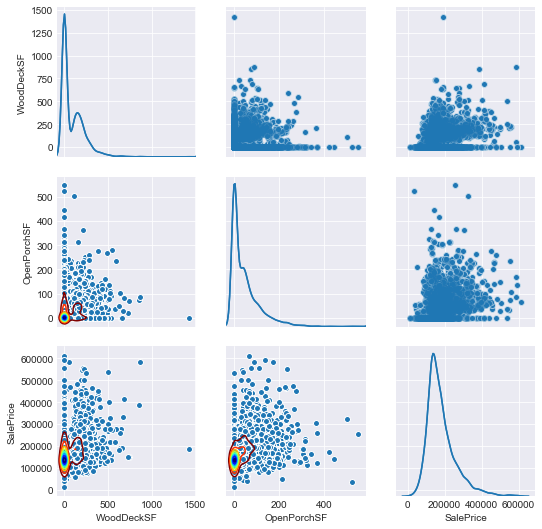

In [86]:
trainN_SF4=train[ [ 'WoodDeckSF','OpenPorchSF', 'SalePrice']]
grid_plot(trainN_SF4)

In [87]:
print(f"Pearson corelation with WoodDeckSF: {train['SalePrice'].corr(train['WoodDeckSF'])}")
print(f"Pearson corelation with OpenPorchSF: {train['SalePrice'].corr(train['OpenPorchSF'])}")

Pearson corelation with WoodDeckSF: 0.32776381498973883
Pearson corelation with OpenPorchSF: 0.3382822630670099


#### No strong correlation detected between WoodDeck and Open Porch SQF . We will take combined of all porch SqFt 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/

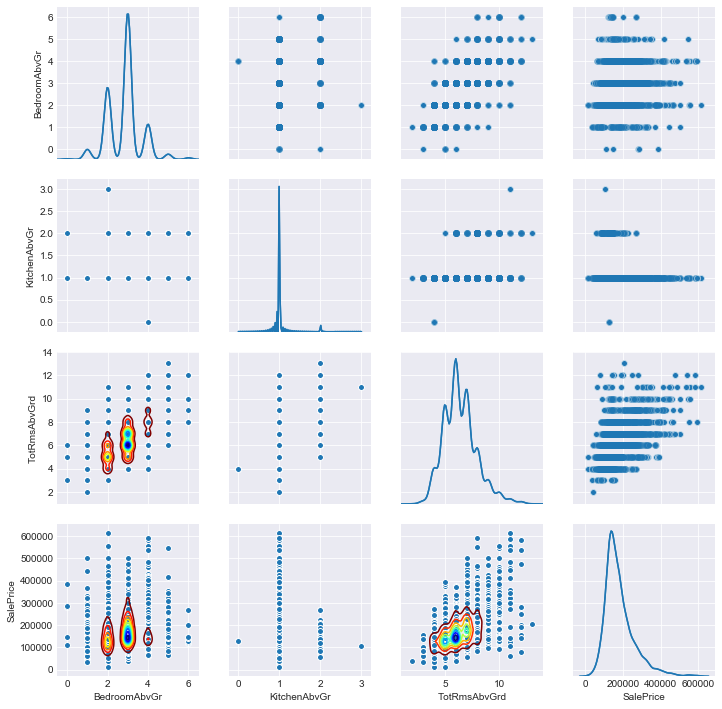

In [88]:
trainN_SF5=train[ [ 'BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd','SalePrice']]
grid_plot(trainN_SF5)

In [89]:
print(f"Pearson corelation with TotRmsAbvGrd: {train['SalePrice'].corr(train['TotRmsAbvGrd'])}")

Pearson corelation with TotRmsAbvGrd: 0.5135215203803783


In [90]:
print(f"Pearson corelation with TotRmsAbvGrd: {train['SalePrice'].corr(train['TotRmsAbvGrd'].map(lambda x: np.log(x)))}")

Pearson corelation with TotRmsAbvGrd: 0.5002916029128449


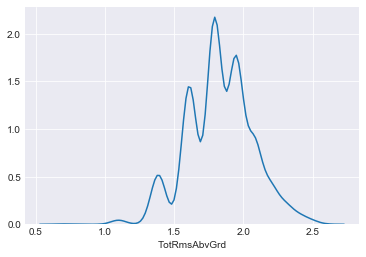

In [91]:
sns.distplot(train['TotRmsAbvGrd'].map(lambda x: np.log(x)), hist=False)

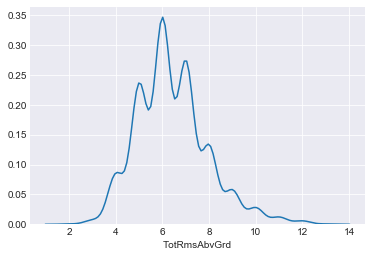

In [92]:
sns.distplot(train['TotRmsAbvGrd'], hist=False)

#### Fairly strong correlation exist for Total rooms above ground. Logarithmic scale reduces the skewness and smoothens the distribution but slightly reduces the correlation. We will try both and see which feature set performs better

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/

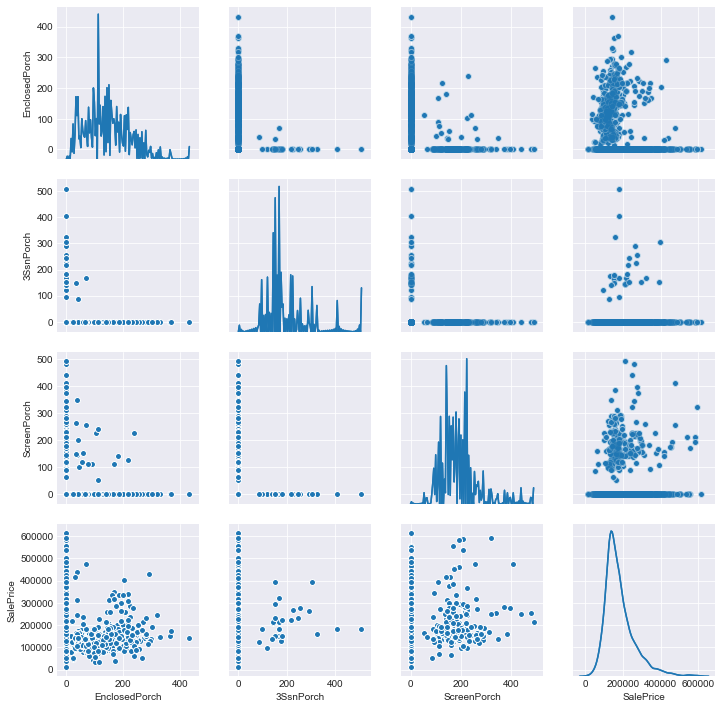

In [93]:
trainN_SF6=train[ [ 'EnclosedPorch','3SsnPorch', 'ScreenPorch','SalePrice']]
grid_plot(trainN_SF6)

In [94]:
print(f"Pearson corelation with ScreenPorch: {train['SalePrice'].corr(train['EnclosedPorch'])}")
print(f"Pearson corelation with ScreenPorch: {train['SalePrice'].corr(train['ScreenPorch'])}")

Pearson corelation with ScreenPorch: -0.13497802228165184
Pearson corelation with ScreenPorch: 0.13513084538305603


#### No interesting correlation

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/

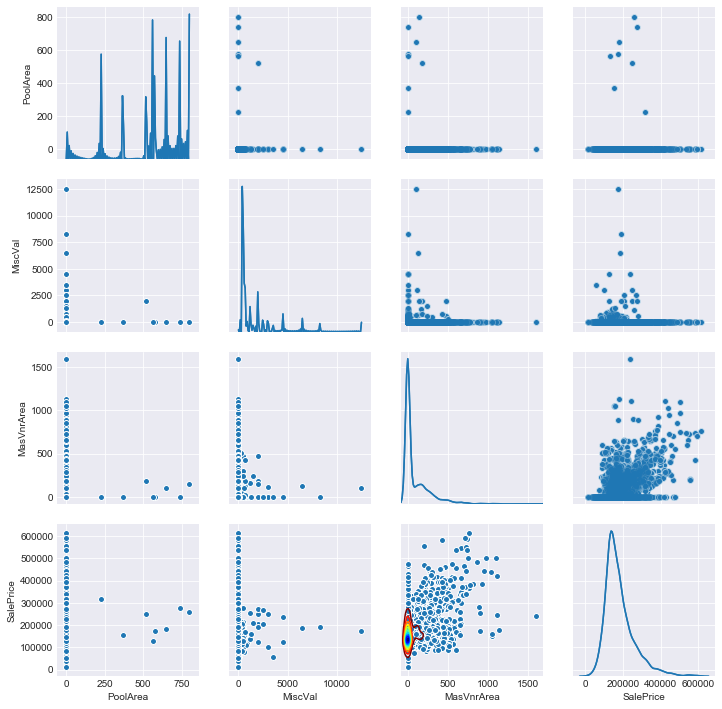

In [95]:
trainN_SF7=train[ [ 'PoolArea','MiscVal', 'MasVnrArea','SalePrice']]
grid_plot(trainN_SF7)

In [96]:
print(f"Pearson corelation with ScreenPorch: {train['SalePrice'].corr(train['MasVnrArea'])}")



Pearson corelation with ScreenPorch: 0.5128631474456817


In [97]:
print(f"Pearson corelation with ScreenPorch: {train['SalePrice'].corr(train['MasVnrArea'].map(lambda x: x**2))}")



Pearson corelation with ScreenPorch: 0.3973304304036685


#### MssVnrArea shows fair correlation

In [98]:
quality_map={'NA':0, 'Po':10, 'Fa':20 , 'TA':30, 'Gd':40, 'Ex':50}

In [99]:
# Assigning number to catgory
def cat_to_num(df,column_name, map_array=quality_map):
    return df[column_name].map(lambda x: quality_map[x])

train['GarageQual_num']=cat_to_num(train, 'GarageQual' )
train['GarageCond_num']=cat_to_num(train, 'GarageCond' )
train['BsmtCond_num']=cat_to_num(train, 'BsmtCond')
train['BsmtQual_num']=cat_to_num(train, 'BsmtQual' )
train['FireplaceQu_num']=cat_to_num(train, 'FireplaceQu' )
train['KitchenQual_num']=cat_to_num(train, 'KitchenQual')
train['HeatingQC_num']=cat_to_num(train, 'HeatingQC')
train['ExterQual_num']=cat_to_num(train, 'ExterQual')
train['ExterCond_num']=cat_to_num(train, 'ExterCond')

In [100]:
test['GarageQual_num']=cat_to_num(test, 'GarageQual' )
test['GarageCond_num']=cat_to_num(test, 'GarageCond' )
test['BsmtCond_num']=cat_to_num(test, 'BsmtCond')
test['BsmtQual_num']=cat_to_num(test, 'BsmtQual' )
test['FireplaceQu_num']=cat_to_num(test, 'FireplaceQu' )
test['KitchenQual_num']=cat_to_num(test, 'KitchenQual')
test['HeatingQC_num']=cat_to_num(test, 'HeatingQC')

In [101]:
train['Age']=train['YearBuilt'].map(lambda x: 2011-x)
test['Age']=test['YearBuilt'].map(lambda x: 2011-x)

In [102]:
train['AgeModeled']=train['YearRemod/Add'].map(lambda x: 2011-x)

In [103]:
train['Age_Built_Model_Diff']=train['Age']-train['AgeModeled']

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous]

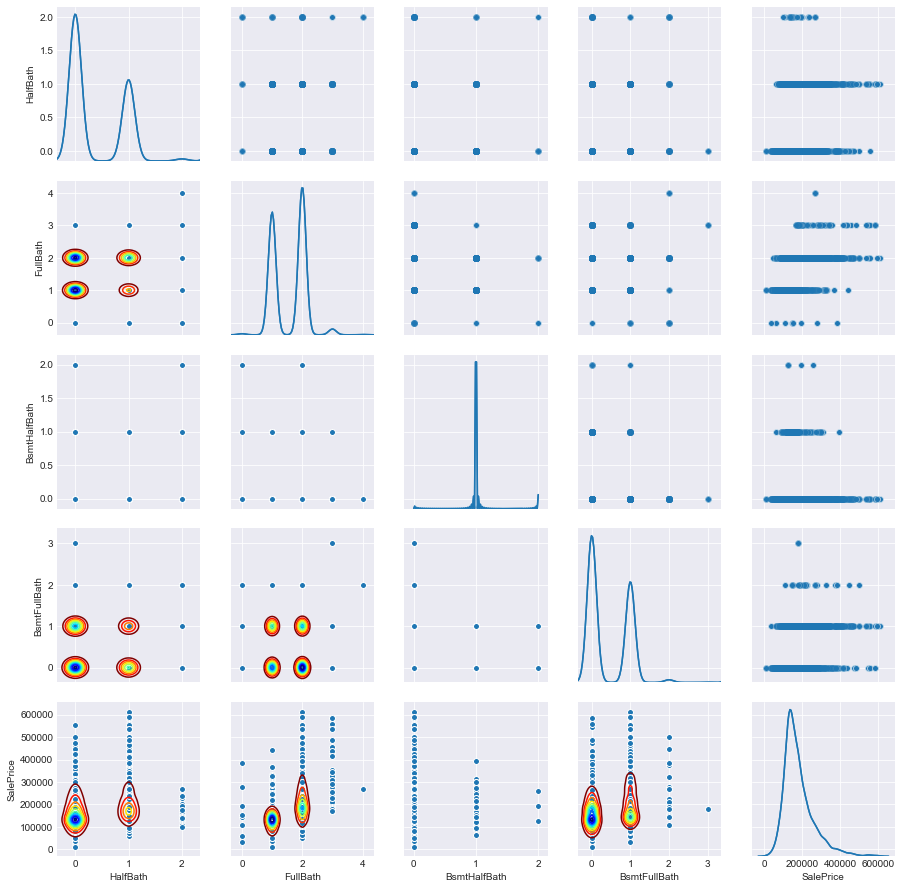

In [104]:
trainN_SF8=train[ [ 'HalfBath','FullBath', 'BsmtHalfBath','BsmtFullBath','SalePrice']]
grid_plot(trainN_SF8)

#### Unable t make any sense of the correlation will try by adding all bathroom square feet

In [105]:
 train['TotalBath_SF']= 0.5*train['HalfBath'] + train['FullBath'] + 0.5*train['BsmtHalfBath'] + train['BsmtFullBath']



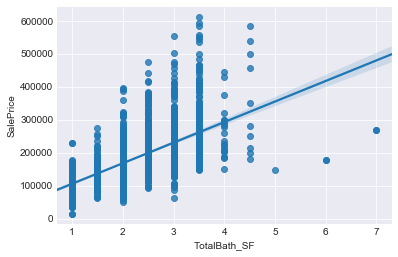

In [106]:
sns.regplot(x=train['TotalBath_SF'],y=train['SalePrice'])

See strong correlation but also notice outliers will try to find outliers and eliminate them

In [107]:
train.loc[(train['TotalBath_SF']>5) & (train['SalePrice']<300000)]

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
791           90       RL    60.000000    10800   Pave      Reg         Lvl   
1566          90       RL   -17.530969    11855   Pave      Reg         Lvl   
1584          90       RL    60.000000    10800   Pave      Reg         Lvl   
1605          90       RL   -17.530969     7939   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope     ...      BsmtQual_num FireplaceQu_num  \
791     AllPub    Inside       Gtl     ...                40               0   
1566    AllPub    Inside       Gtl     ...                50              30   
1584    AllPub    Inside       Gtl     ...                40               0   
1605    AllPub    Inside       Gtl     ...                50              30   

     KitchenQual_num HeatingQC_num ExterQual_num  ExterCond_num  Age  \
791               30            30            30             30   24   
1566              30            50            30             30   11   
1584              30            30            30             40   24   
1605              30            50            30             30   11   

      AgeModeled  Age_Built_Model_Diff TotalBath_SF  
791           23                     1          6.0  
1566          11                     0          7.0  
1584          23                     1          6.0  
1605          11                     0          7.0  

[4 rows x 88 columns]

In [108]:
train.drop([791, 1566, 1584, 1605 ], inplace=True)

Text(0,0.5,'Sales Price')

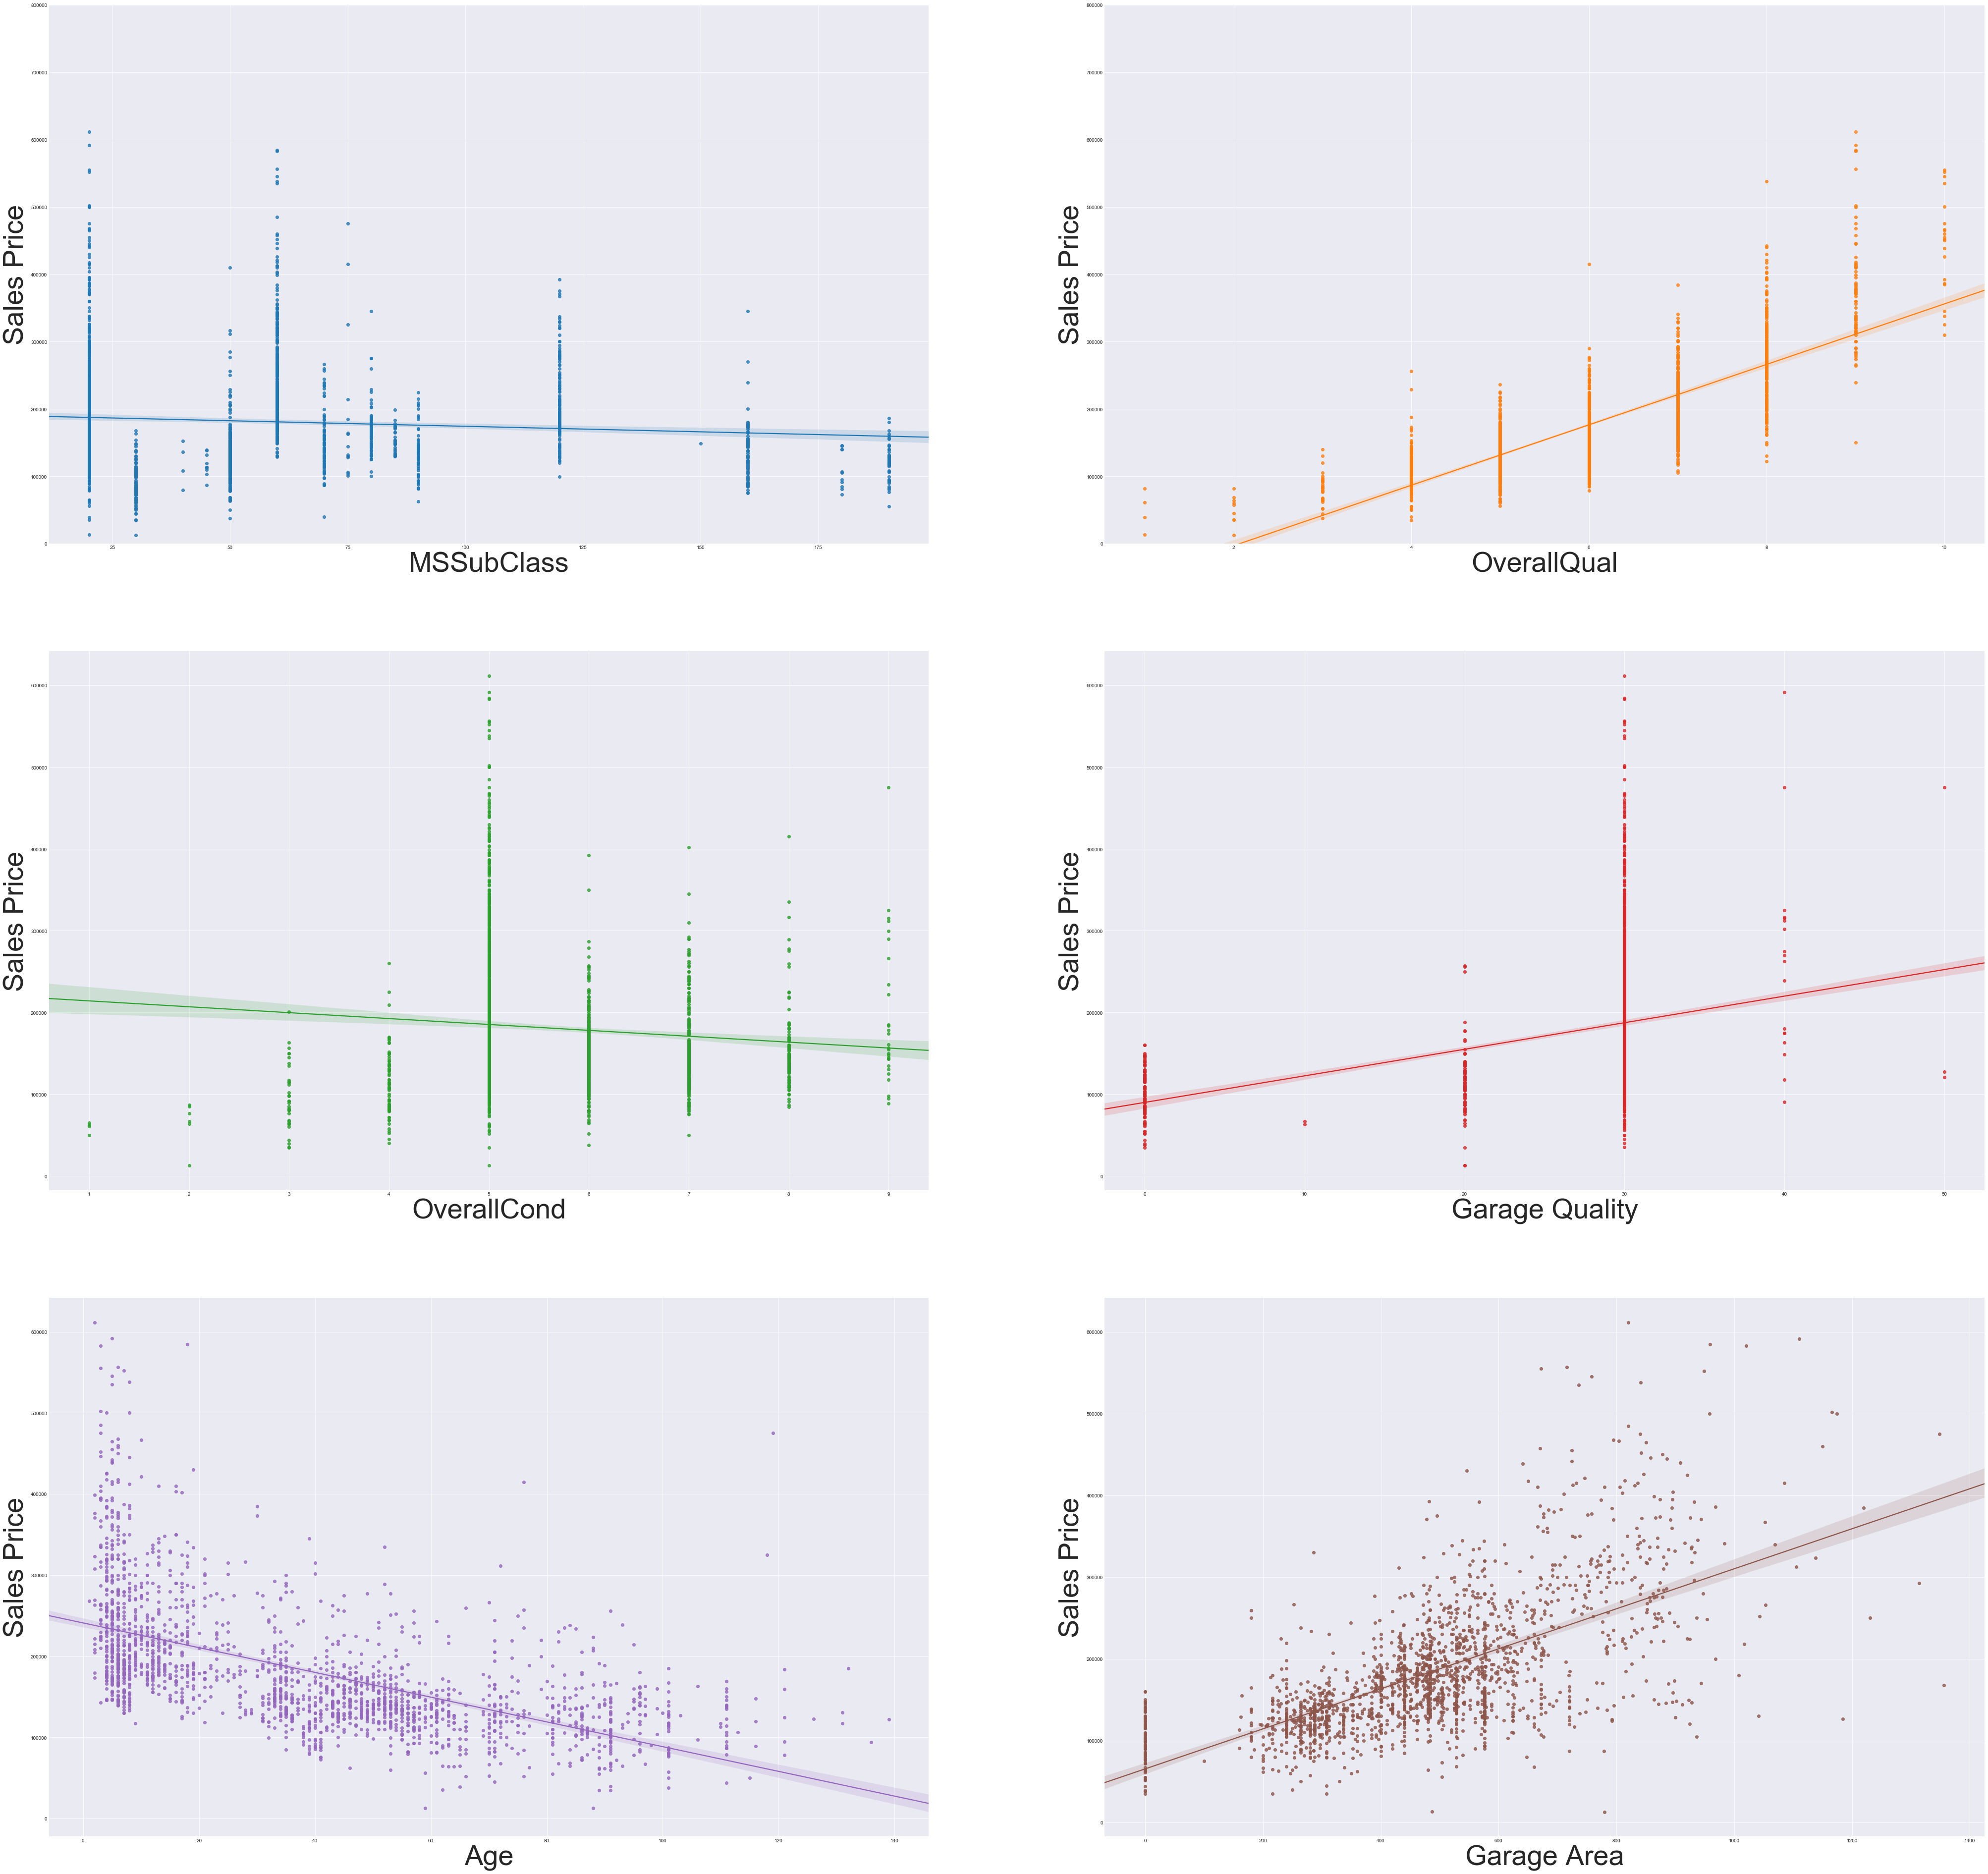

In [109]:
fig, ax=plt.subplots(3,2, figsize=(70, 68))
sns.regplot(x='MSSubClass', y='SalePrice', data=train, ax=ax[0,0])
ax[0, 0].set_xlabel("MSSubClass", fontsize=56)
ax[0, 0].set_ylabel("Sales Price", fontsize=56)
ax[0, 0].set_ylim(0, 800000)
sns.regplot(x='OverallQual', y='SalePrice', data=train, ax=ax[0,1])
ax[0, 1].set_xlabel("OverallQual", fontsize=56)
ax[0, 1].set_ylabel("Sales Price", fontsize=56)
ax[0, 1].set_ylim(0, 800000)
sns.regplot(x='OverallCond', y='SalePrice', data=train, ax=ax[1,0])
ax[1, 0].set_xlabel("OverallCond", fontsize=56)
ax[1, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="GarageQual_num", y="SalePrice", data=train, ax=ax[1,1])
ax[1, 1].set_xlabel("Garage Quality", fontsize=56)
ax[1, 1].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="Age", y="SalePrice", data=train, ax=ax[2,0])
ax[2, 0].set_xlabel("Age", fontsize=56)
ax[2, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="GarageArea", y="SalePrice", data=train, ax=ax[2,1])
ax[2, 1].set_xlabel("Garage Area", fontsize=56)
ax[2, 1].set_ylabel("Sales Price", fontsize=56)

In [110]:
print(f"Pearson corelation with Garage Condition: {train['SalePrice'].corr(train['GarageCond_num'])}")
print(f"Pearson corelation with Garage Quaity: {train['SalePrice'].corr(train['GarageQual_num'])}")

Pearson corelation with Garage Condition: 0.27004823784984144
Pearson corelation with Garage Quaity: 0.2906073416962207


Text(0,0.5,'Sales Price')

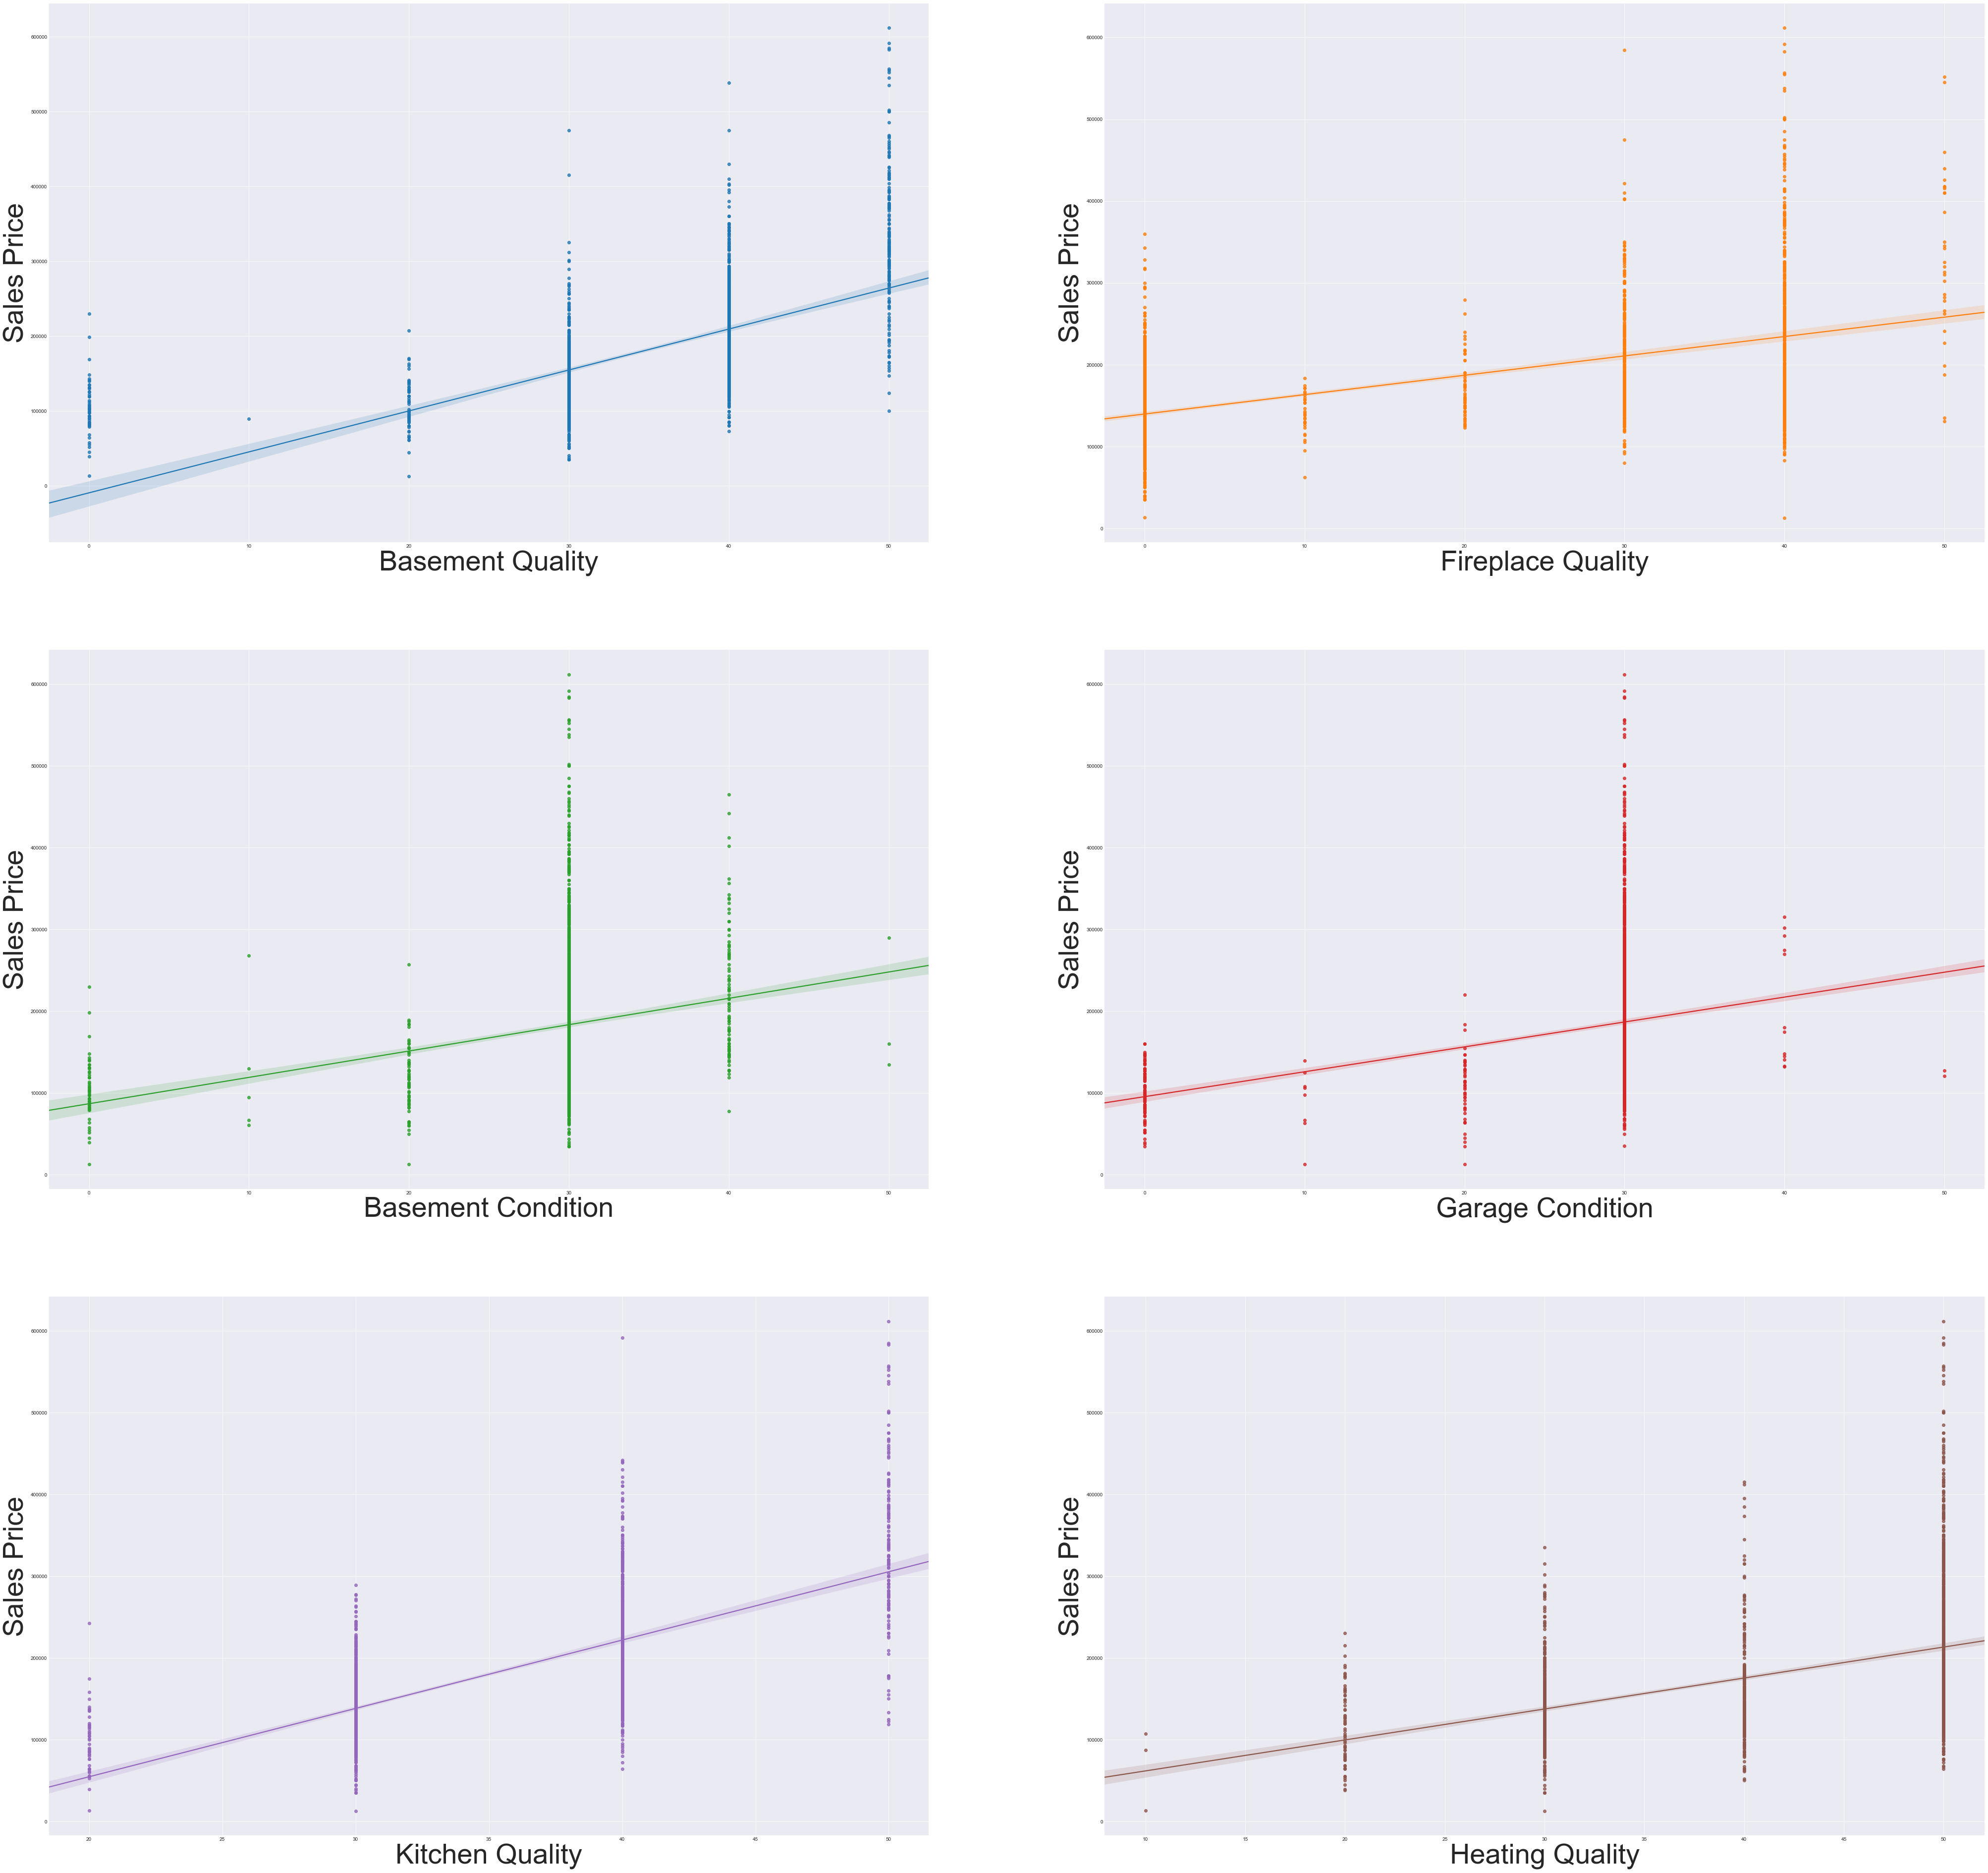

In [111]:
fig, ax=plt.subplots(3,2, figsize=(70, 68))
sns.regplot(x="BsmtQual_num", y="SalePrice", data=train, ax=ax[0,0])
ax[0, 0].set_xlabel("Basement Quality", fontsize=56)
ax[0, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="FireplaceQu_num", y="SalePrice", data=train, ax=ax[0,1])
ax[0, 1].set_xlabel("Fireplace Quality", fontsize=56)
ax[0, 1].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="BsmtCond_num", y="SalePrice", data=train, ax=ax[1,0])
ax[1, 0].set_xlabel("Basement Condition", fontsize=56)
ax[1, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="GarageCond_num", y="SalePrice", data=train, ax=ax[1,1])
ax[1, 1].set_xlabel("Garage Condition", fontsize=56)
ax[1, 1].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="KitchenQual_num", y="SalePrice", data=train, ax=ax[2,0])
ax[2, 0].set_xlabel("Kitchen Quality", fontsize=56)
ax[2, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="HeatingQC_num", y="SalePrice", data=train, ax=ax[2,1])
ax[2, 1].set_xlabel("Heating Quality", fontsize=56)
ax[2, 1].set_ylabel("Sales Price", fontsize=56)

In [112]:
print(f"Pearson corelation with Basement Condition: {train['SalePrice'].corr(train['BsmtCond_num'])}")
print(f"Pearson corelation with Basement Quaity: {train['SalePrice'].corr(train['BsmtQual_num'])}")

Pearson corelation with Basement Condition: 0.23076846281479668
Pearson corelation with Basement Quaity: 0.6189923743434204


#### Basement Quality will be chosen over condition

Text(0,0.5,'Sales Price')

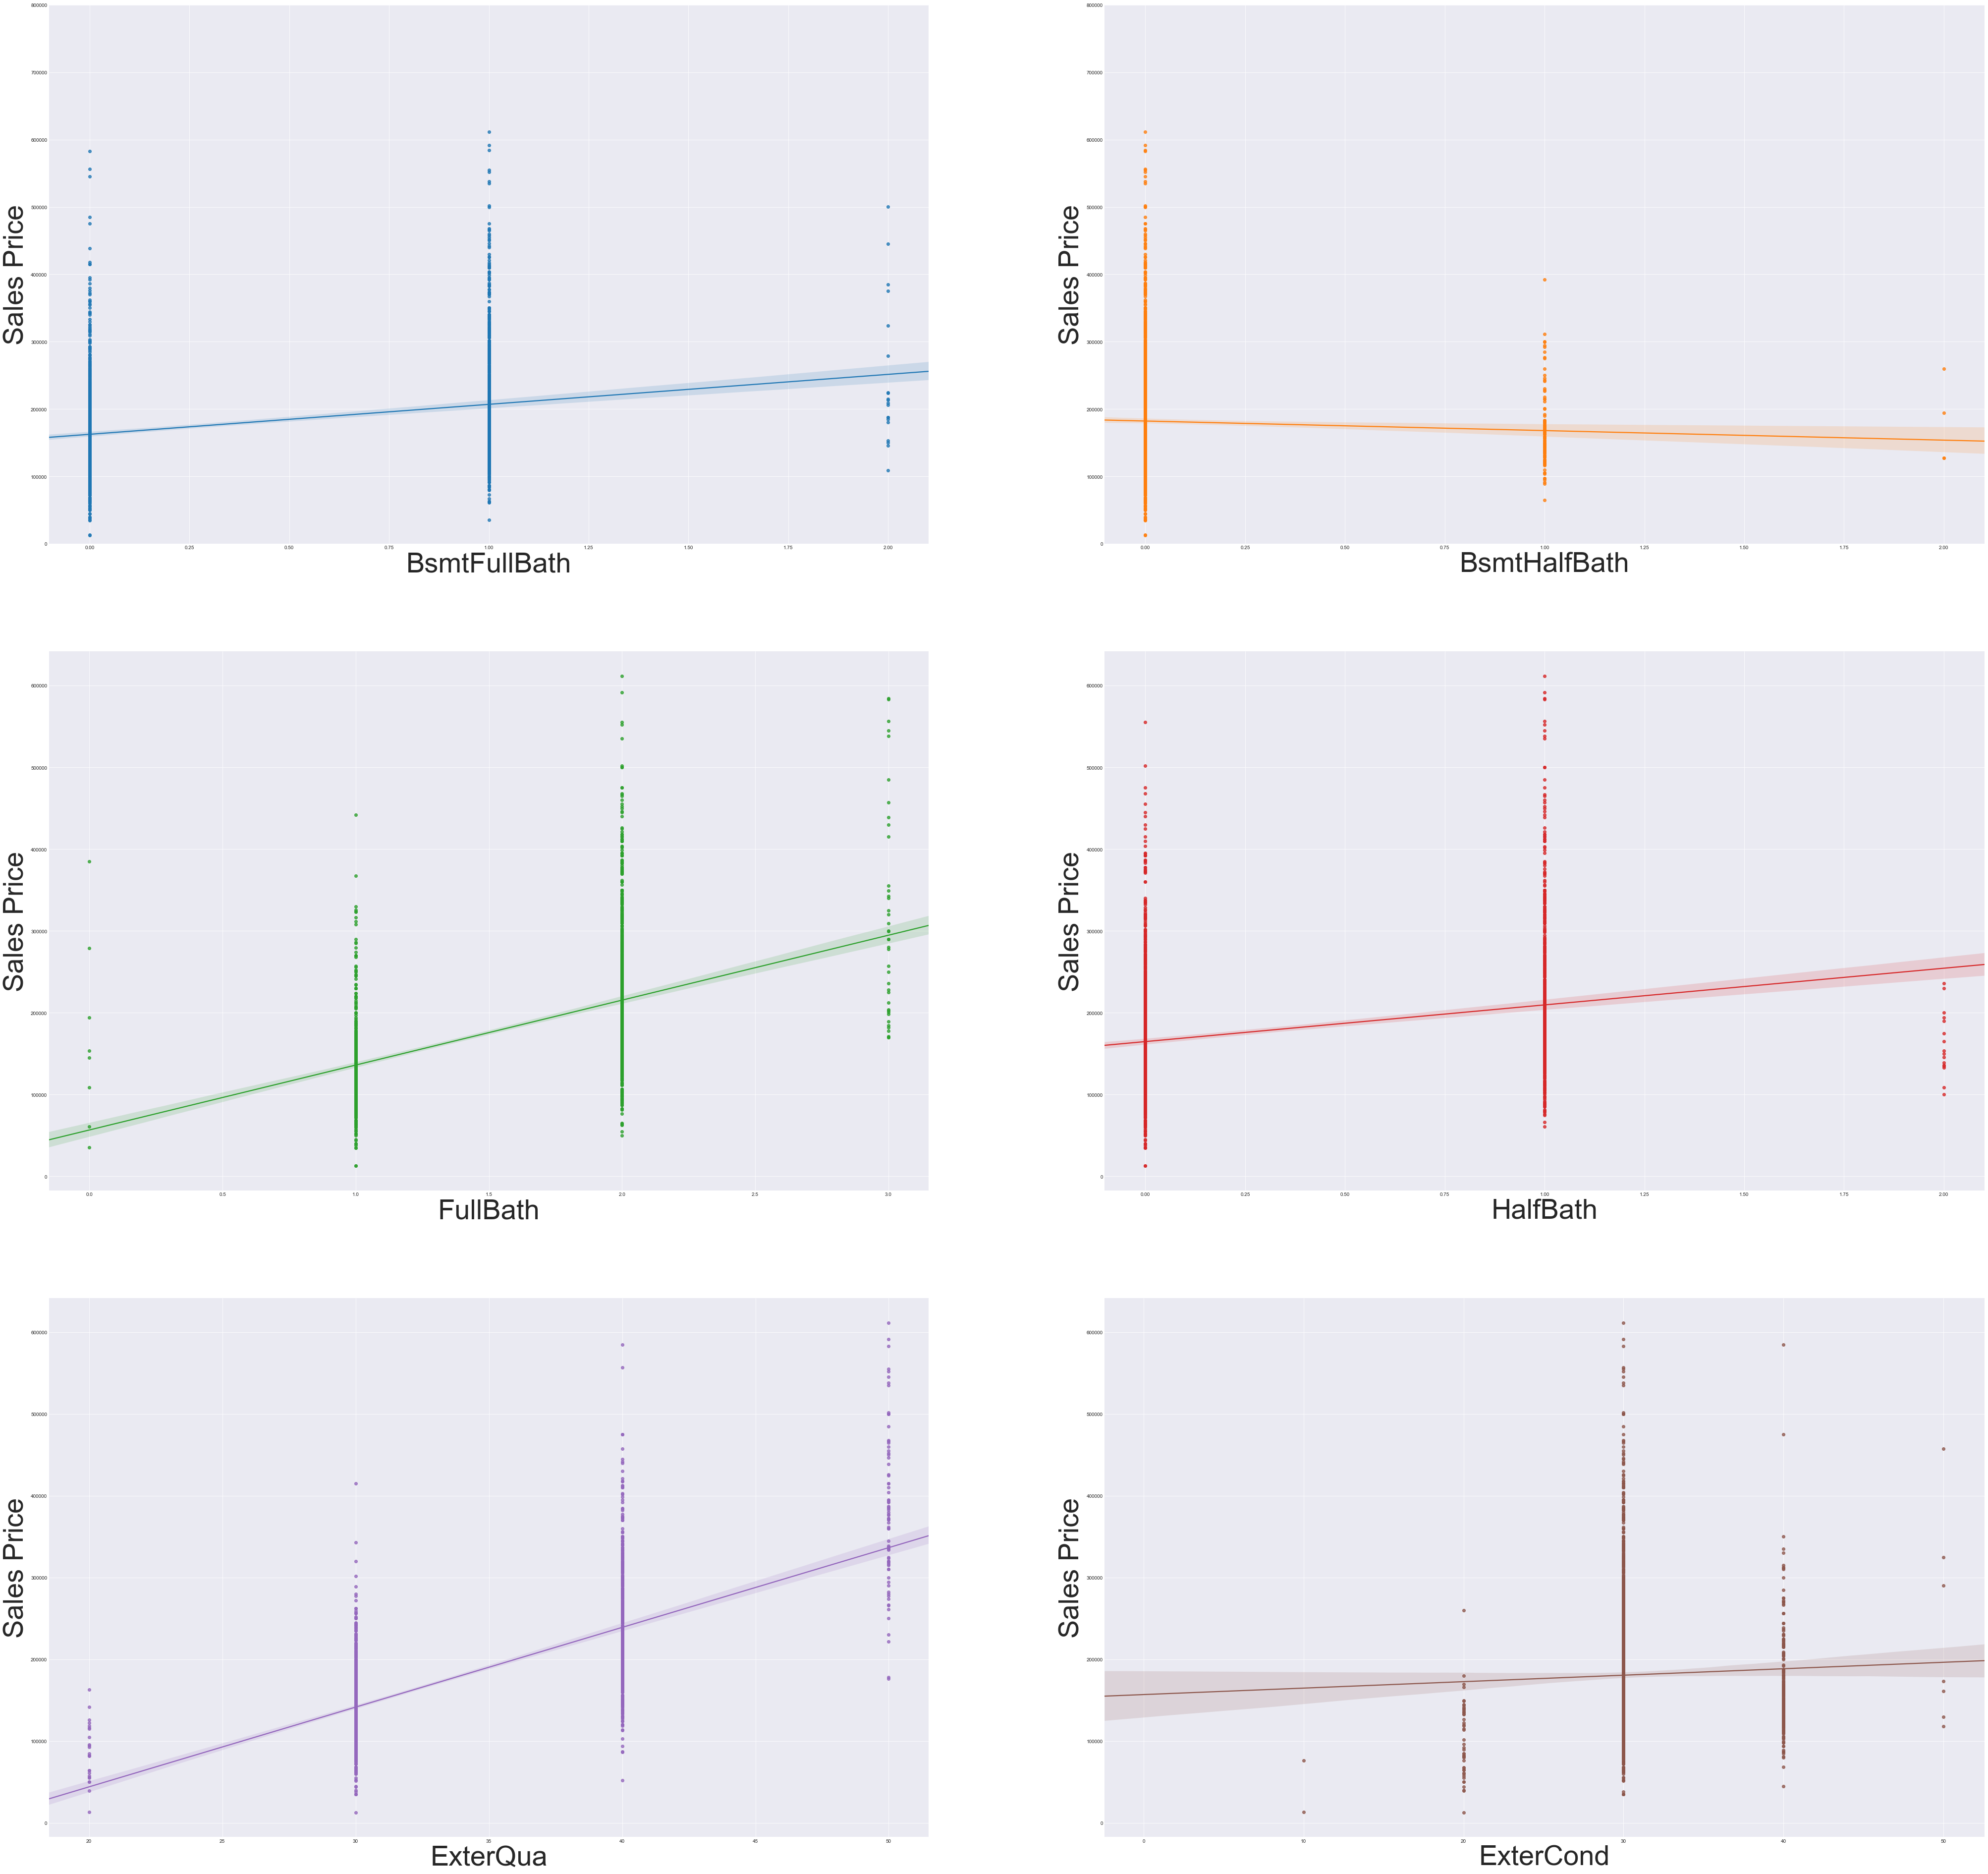

In [113]:
fig, ax=plt.subplots(3,2, figsize=(70, 68))
sns.regplot(x='BsmtFullBath', y='SalePrice', data=train, ax=ax[0,0])
ax[0, 0].set_xlabel("BsmtFullBath", fontsize=56)
ax[0, 0].set_ylabel("Sales Price", fontsize=56)
ax[0, 0].set_ylim(0, 800000)
sns.regplot(x='BsmtHalfBath', y='SalePrice', data=train, ax=ax[0,1])
ax[0, 1].set_xlabel("BsmtHalfBath", fontsize=56)
ax[0, 1].set_ylabel("Sales Price", fontsize=56)
ax[0, 1].set_ylim(0, 800000)
sns.regplot(x='FullBath', y='SalePrice', data=train, ax=ax[1,0])
ax[1, 0].set_xlabel("FullBath", fontsize=56)
ax[1, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="HalfBath", y="SalePrice", data=train, ax=ax[1,1])
ax[1, 1].set_xlabel("HalfBath", fontsize=56)
ax[1, 1].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x='ExterQual_num', y='SalePrice', data=train, ax=ax[2,0])
ax[2, 0].set_xlabel("ExterQua", fontsize=56)
ax[2, 0].set_ylabel("Sales Price", fontsize=56)
sns.regplot(x="ExterCond_num", y="SalePrice", data=train, ax=ax[2,1])
ax[2, 1].set_xlabel("ExterCond", fontsize=56)
ax[2, 1].set_ylabel("Sales Price", fontsize=56)


### Plotting Categorical Variables

Text(0.5,1,'Lot contour and impact on price')

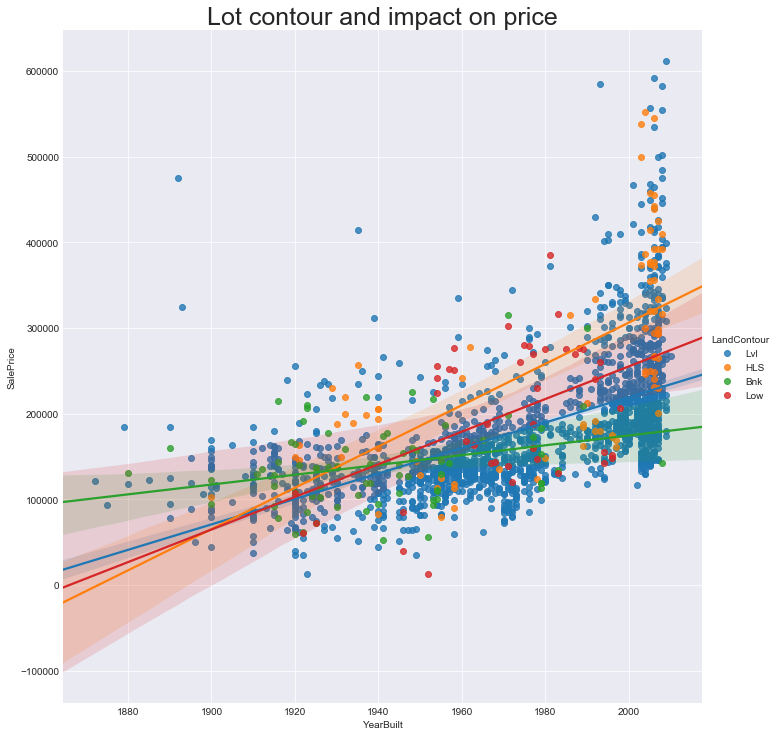

In [114]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="LandContour", data=train, size=10)
plt.title('Lot contour and impact on price', fontsize=25)

In [115]:
train['LandContour'].value_counts(normalize=True)

Lvl    0.899951
HLS    0.041687
Bnk    0.037273
Low    0.021089
Name: LandContour, dtype: float64

#### We will consider Land Contour has interesting feature

Text(0.5,1,'Building type and impact on price')

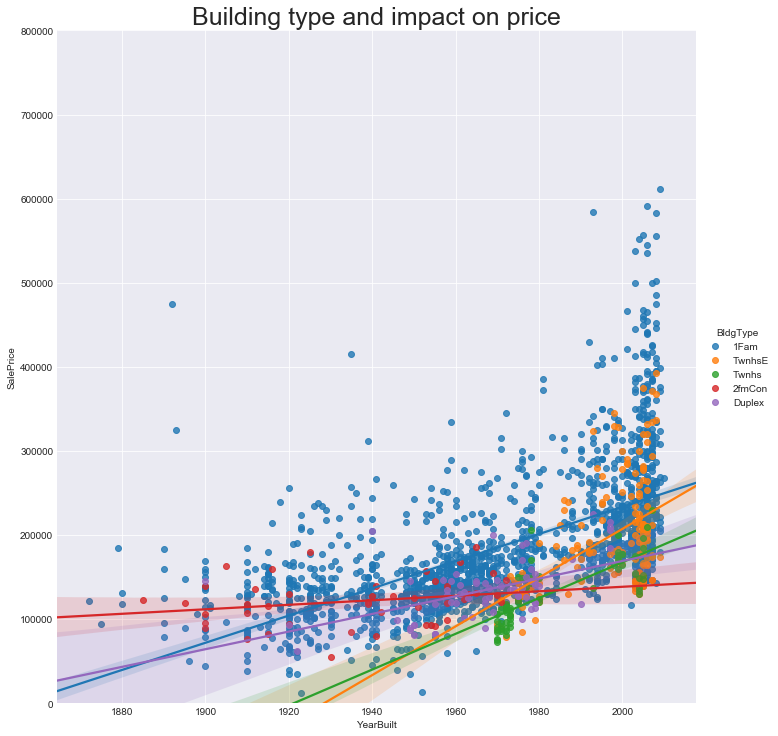

In [116]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="BldgType", data=train, size=10)
plt.ylim(0, 800000)
plt.title('Building type and impact on price', fontsize=25)

In [117]:
train['BldgType'].value_counts(normalize=True)

1Fam      0.830309
TwnhsE    0.078960
Duplex    0.034821
Twnhs     0.033840
2fmCon    0.022070
Name: BldgType, dtype: float64

#### Building type is a important feature

Text(0.5,1,'House Style and impact on price')

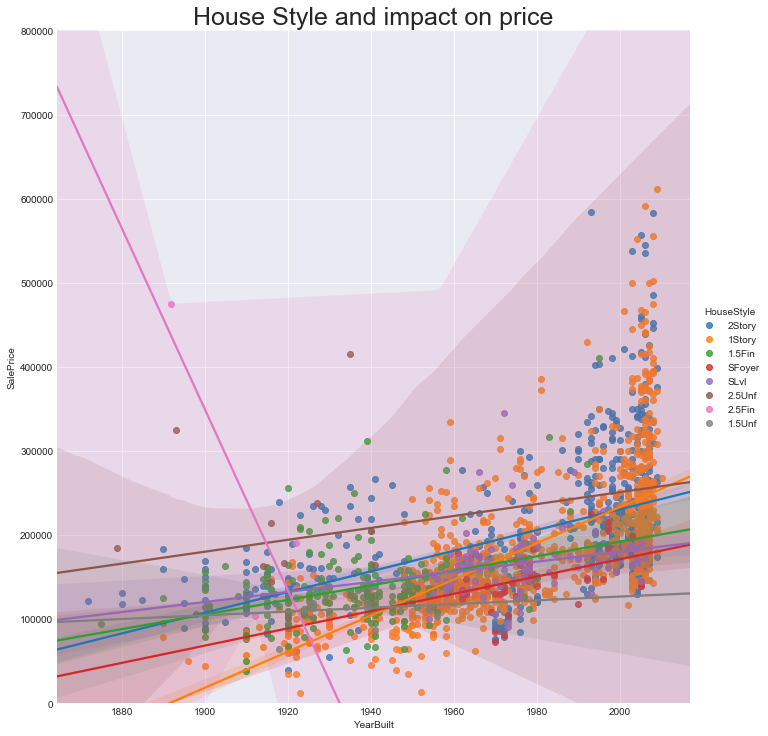

In [118]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="HouseStyle", data=train, size=10)
plt.ylim(0, 800000)
plt.title('House Style and impact on price', fontsize=25)

In [119]:
train['HouseStyle'].value_counts(normalize=True)

1Story    0.517410
2Story    0.291319
1.5Fin    0.106425
SLvl      0.046101
SFoyer    0.024522
2.5Unf    0.006866
1.5Unf    0.005885
2.5Fin    0.001471
Name: HouseStyle, dtype: float64

#### House style is an important feature

Text(0.5,1,'Masonry veneer type and impact on price')

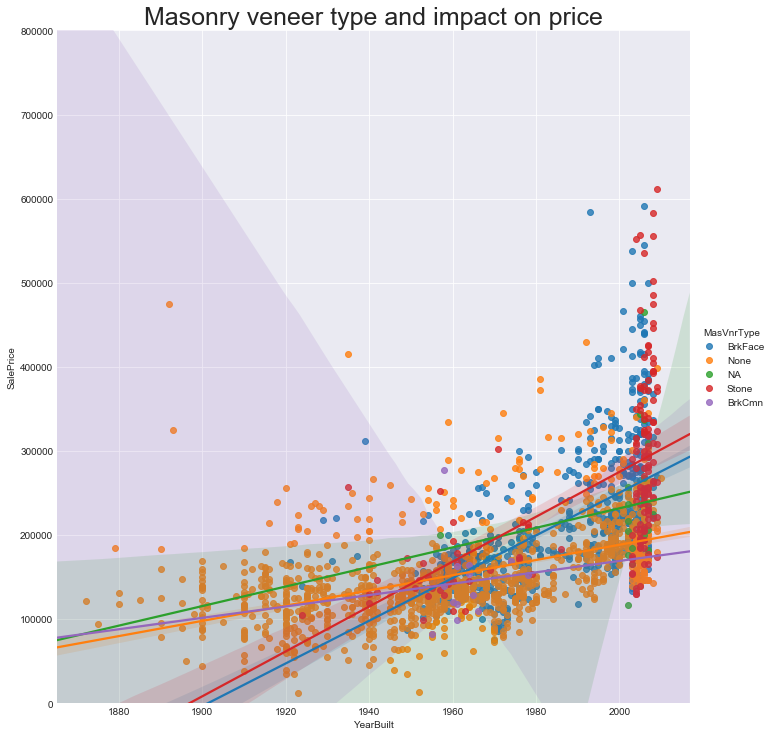

In [120]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="MasVnrType", data=train, size=10)
plt.ylim(0, 800000)
plt.title('Masonry veneer type and impact on price', fontsize=25)

In [121]:
train['MasVnrType'].value_counts(normalize=True)

None       0.593428
BrkFace    0.307994
Stone      0.081412
NA         0.010790
BrkCmn     0.006376
Name: MasVnrType, dtype: float64

#### MsnVnrType is important feature

Text(0.5,1,'Neighborhood and impact on price')

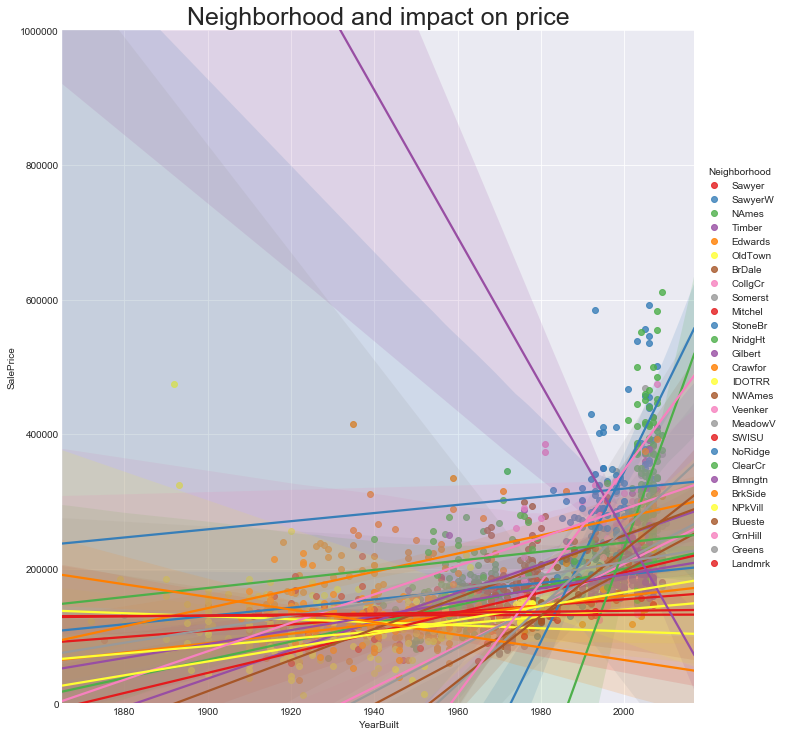

In [122]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="Neighborhood", data=train, palette="Set1", size=10)
plt.ylim(0, 1000000)
plt.title('Neighborhood and impact on price', fontsize=25)

Text(0.5,1,'Garage Type and impact on price')

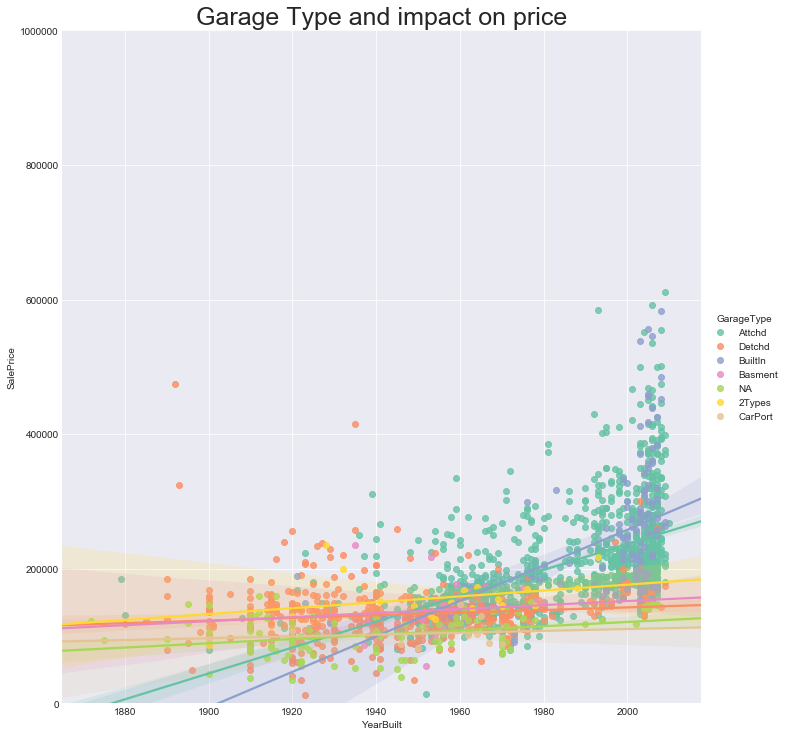

In [123]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="GarageType", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Garage Type and impact on price', fontsize=25)

In [124]:
train['GarageType'].value_counts(normalize=True)

Attchd     0.592938
Detchd     0.262384
BuiltIn    0.063757
NA         0.053458
Basment    0.012751
2Types     0.009318
CarPort    0.005395
Name: GarageType, dtype: float64

#### Garage Type is important feature

Text(0.5,1,'Electrical Type and impact on price')

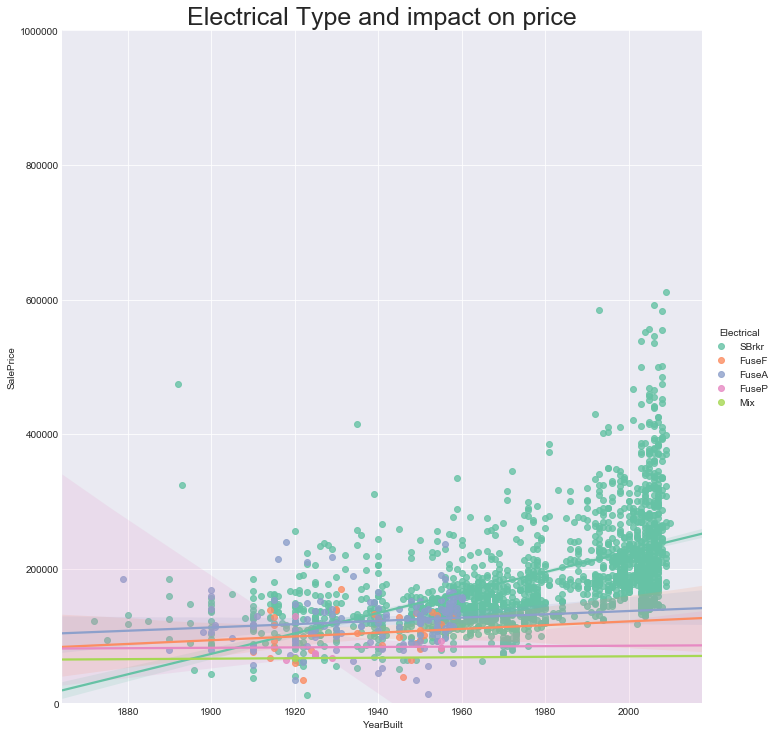

In [125]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="Electrical", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Electrical Type and impact on price', fontsize=25)

In [126]:
train['Electrical'].value_counts(normalize=True)

SBrkr    0.910741
FuseA    0.068171
FuseF    0.017165
FuseP    0.003433
Mix      0.000490
Name: Electrical, dtype: float64

#### Electrical type will be ignored

Text(0.5,1,'Basement Finish Type 1 and impact on price')

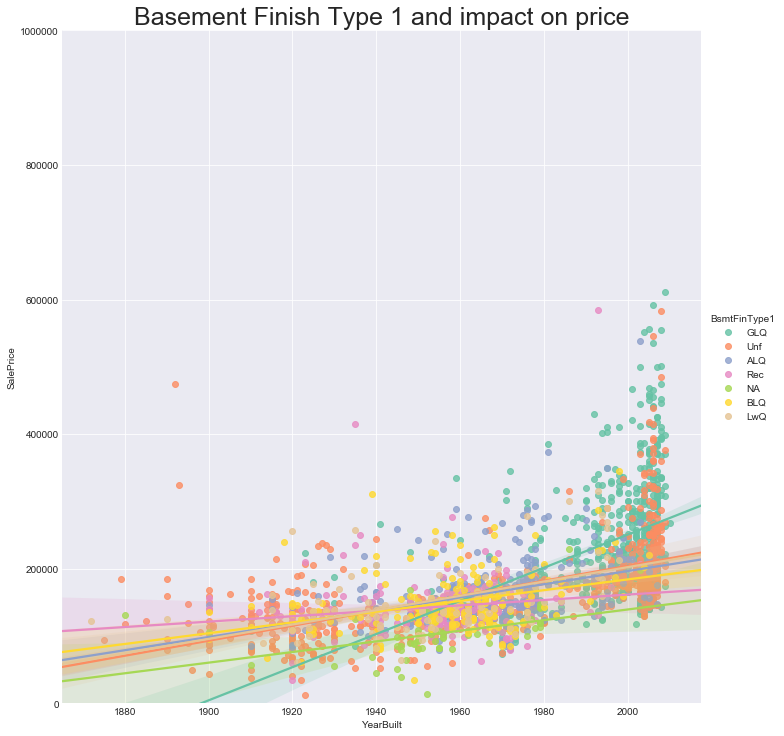

In [127]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="BsmtFinType1", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Basement Finish Type 1 and impact on price', fontsize=25)

In [128]:
train['BsmtFinType1'].value_counts(normalize=True)

GLQ    0.298185
Unf    0.295243
ALQ    0.143207
BLQ    0.098087
Rec    0.089259
LwQ    0.049534
NA     0.026484
Name: BsmtFinType1, dtype: float64

#### Basement finish type 1  is important feature

Text(0.5,1,'Basement Finish Type 2 and impact on price')

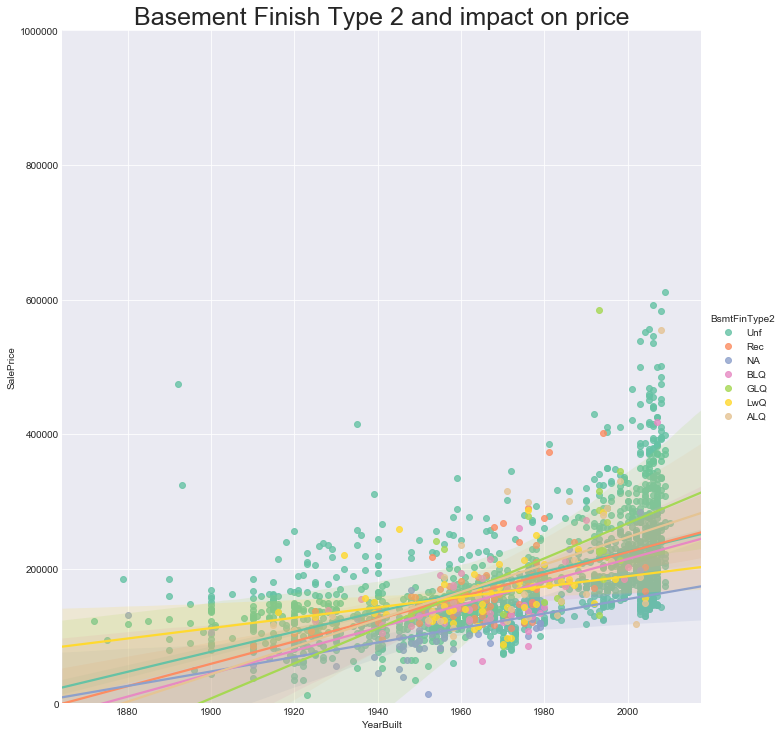

In [129]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="BsmtFinType2", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Basement Finish Type 2 and impact on price', fontsize=25)

In [130]:
train['BsmtFinType2'].value_counts(normalize=True)

Unf    0.852869
Rec    0.039235
LwQ    0.029426
NA     0.026974
BLQ    0.023051
ALQ    0.017165
GLQ    0.011280
Name: BsmtFinType2, dtype: float64

#### Basement finish type 2  is important feature

Text(0.5,1,'Garage Finish and impact on price')

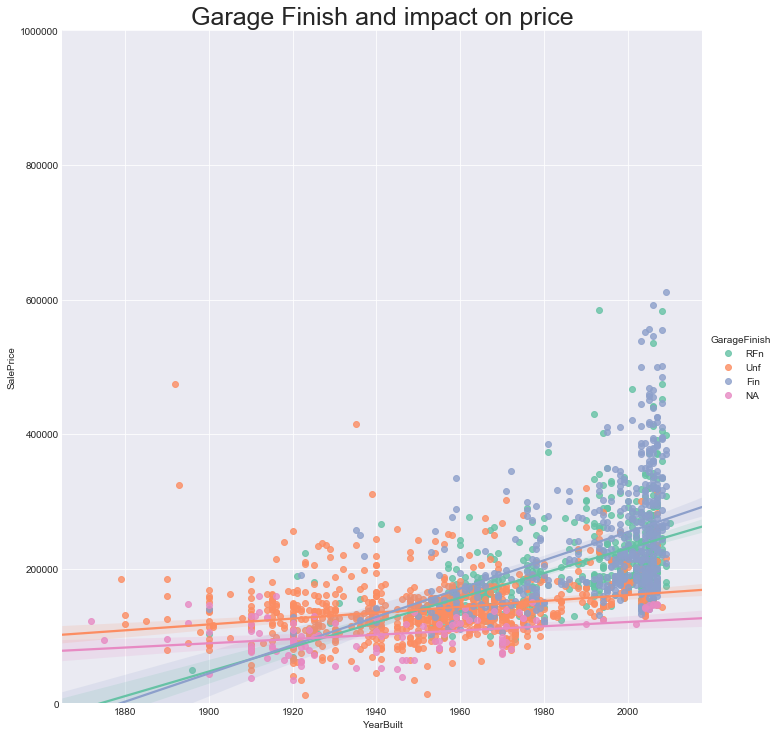

In [131]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="GarageFinish", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Garage Finish and impact on price', fontsize=25)

In [132]:
train['GarageFinish'].value_counts(normalize=True)

Unf    0.415400
RFn    0.283963
Fin    0.247180
NA     0.053458
Name: GarageFinish, dtype: float64

#### Garage finish type is important feature

Text(0.5,1,'Functional and impact on price')

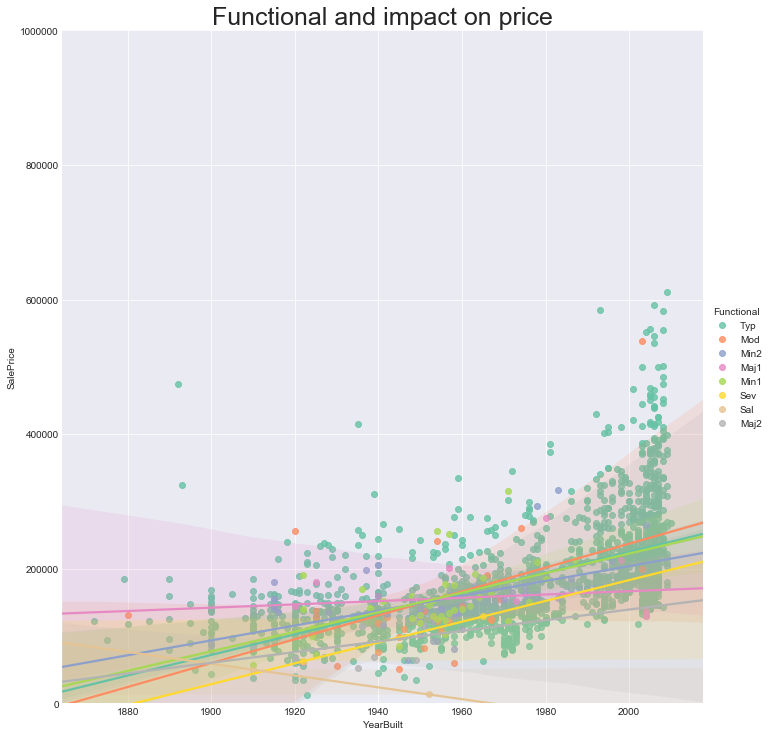

In [133]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="Functional", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Functional and impact on price', fontsize=25)

In [134]:
train['Functional'].value_counts(normalize=True)

Typ     0.933791
Min1    0.020598
Min2    0.020598
Mod     0.014223
Maj1    0.005395
Maj2    0.003433
Sev     0.000981
Sal     0.000981
Name: Functional, dtype: float64

Text(0.5,1,'Paved Drive and impact on price')

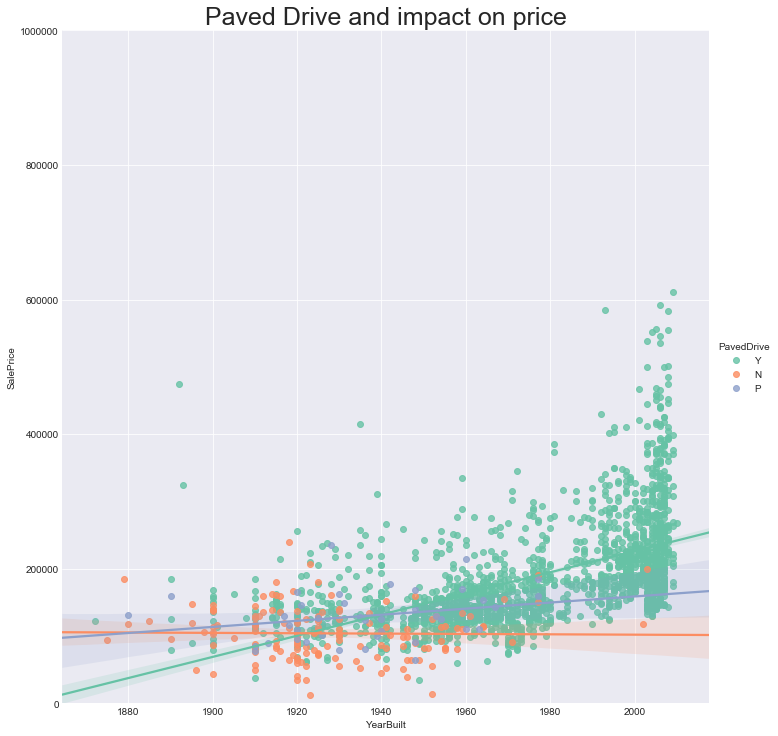

In [135]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="PavedDrive", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Paved Drive and impact on price', fontsize=25)

In [136]:
train['PavedDrive'].value_counts(normalize=True)

Y    0.907308
N    0.073565
P    0.019127
Name: PavedDrive, dtype: float64

Text(0.5,1,'Heating and impact on price')

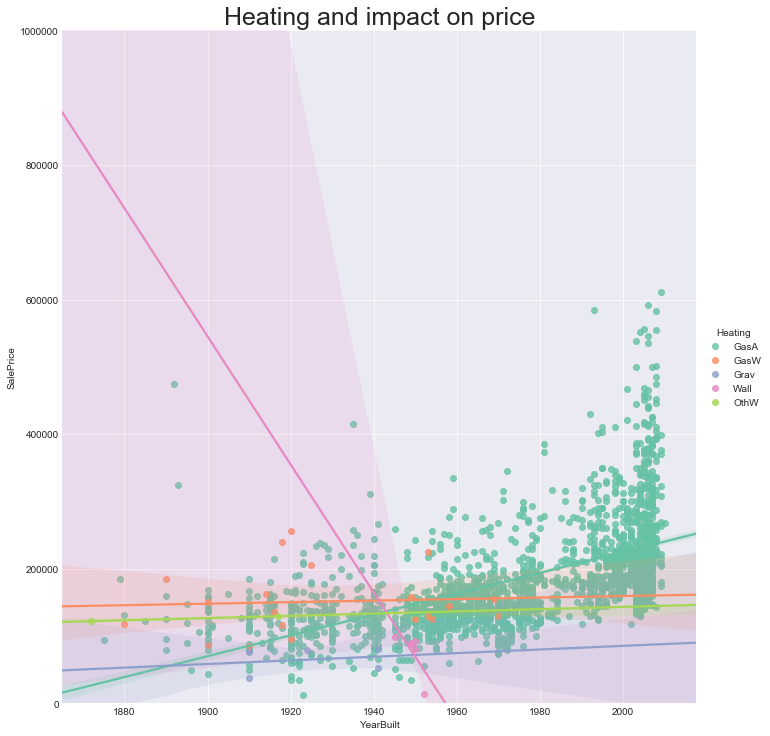

In [137]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="Heating", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Heating and impact on price', fontsize=25)

In [138]:
train['Heating'].value_counts(normalize=True)

GasA    0.983816
GasW    0.009809
Wall    0.002943
Grav    0.002452
OthW    0.000981
Name: Heating, dtype: float64

Text(0.5,1,'Cenral Aircondition  and impact on price')

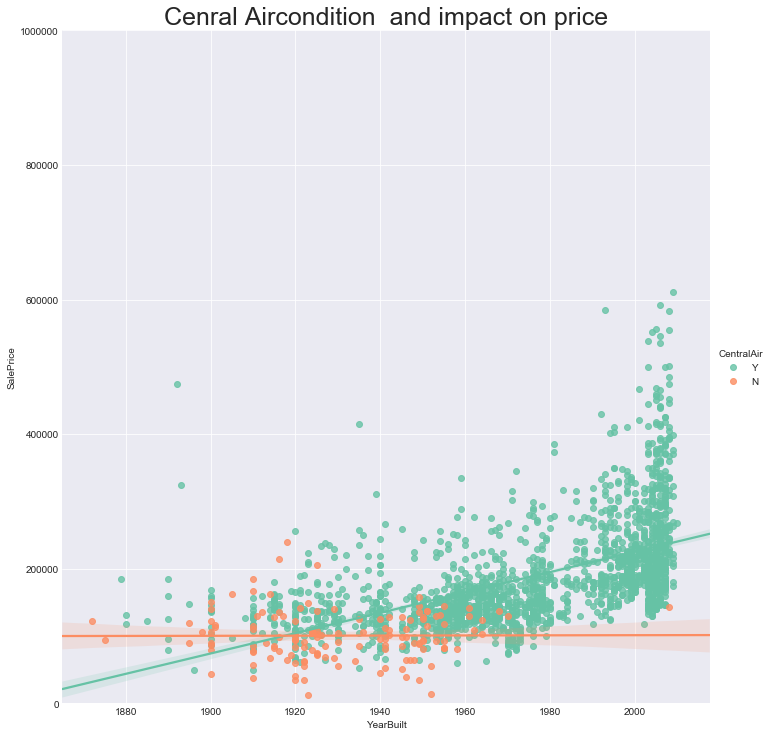

In [139]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="CentralAir", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Cenral Aircondition  and impact on price', fontsize=25)

In [140]:
train['CentralAir'].value_counts(normalize=True)

Y    0.930848
N    0.069152
Name: CentralAir, dtype: float64

Text(0.5,1,'Basement Exposure and impact on price')

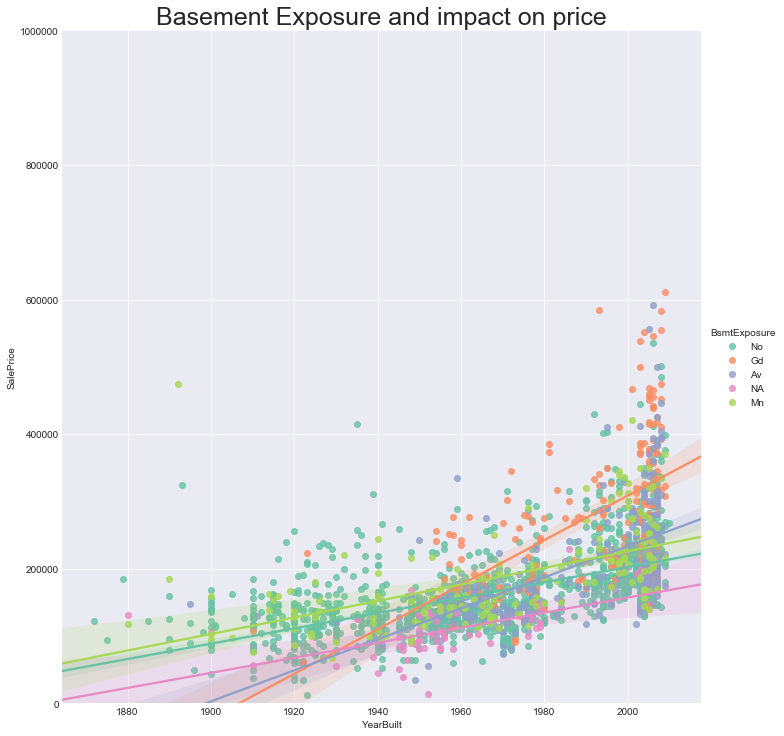

In [141]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="BsmtExposure", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Basement Exposure and impact on price', fontsize=25)

In [142]:
train['BsmtExposure'].value_counts(normalize=True)

No    0.653261
Av    0.141246
Gd    0.097597
Mn    0.079941
NA    0.027955
Name: BsmtExposure, dtype: float64

Text(0.5,1,'Exterior 1st and impact on price')

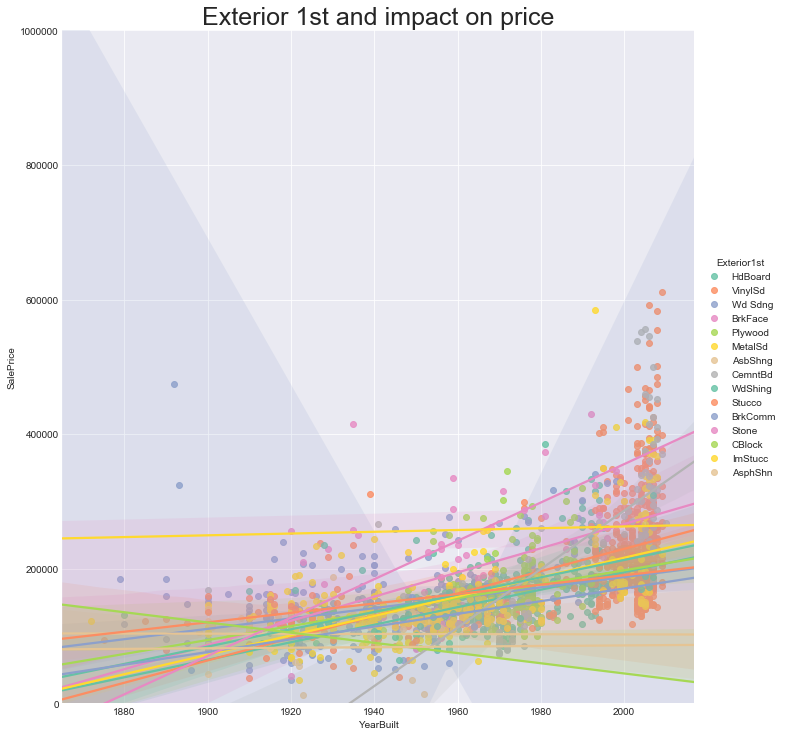

In [143]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="Exterior1st", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('Exterior 1st and impact on price', fontsize=25)

In [144]:
train['Exterior1st'].value_counts(normalize=True)

VinylSd    0.353605
MetalSd    0.161844
HdBoard    0.147131
Wd Sdng    0.134380
Plywood    0.073075
CemntBd    0.043158
BrkFace    0.031388
WdShing    0.022070
AsbShng    0.016184
Stucco     0.012751
BrkComm    0.001471
CBlock     0.000981
Stone      0.000981
ImStucc    0.000490
AsphShn    0.000490
Name: Exterior1st, dtype: float64

Text(0.5,1,'BRoof Style and impact on price')

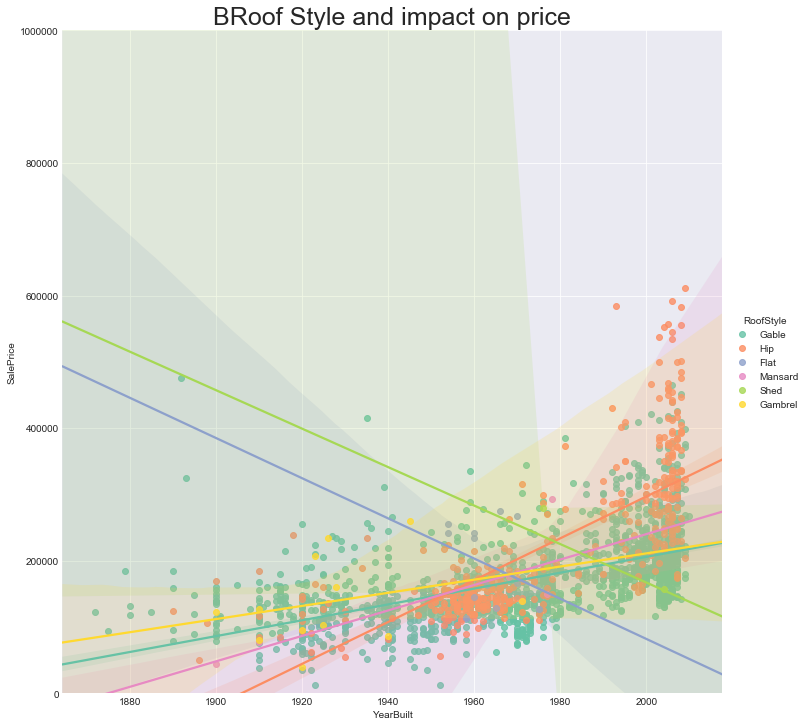

In [145]:
sns.lmplot(x="YearBuilt", y="SalePrice", hue="RoofStyle", data=train, palette="Set2", size=10)
plt.ylim(0, 1000000)
plt.title('BRoof Style and impact on price', fontsize=25)

In [146]:
train['RoofStyle'].value_counts(normalize=True)

Gable      0.790584
Hip        0.192251
Flat       0.006376
Gambrel    0.005885
Mansard    0.003433
Shed       0.001471
Name: RoofStyle, dtype: float64

In [147]:
# Roof Matl
train['RoofMatl'].value_counts(normalize=True)

CompShg    0.987739
Tar&Grv    0.007357
WdShngl    0.002452
WdShake    0.001962
Membran    0.000490
Name: RoofMatl, dtype: float64

#### Basement exposure is an important feature

#### Due to poor variance we will ignore following categorical features

- Electrical

- Functional

- Heating

- Paved Drive

- Central Air conditioning

## Feature Selection

#### Based on EDA we will first manually select the features. Then we will use automatic feature selection to improve the performance

In [148]:
# Training
# First feature set
trainFS1=pd.DataFrame()
trainFS1['LotAreaLog']=train['LotArea'].map(lambda x: np.log(x))
trainFS1['TotRmsAbvGrd']=train['TotRmsAbvGrd']
trainFS1['MasVnrArea']=train['MasVnrArea']
trainFS1['GarageQual_num']=train['GarageQual_num']
trainFS1['OverallQual']=train['OverallQual']
trainFS1['GarageArea']=train['GarageArea']
trainFS1['BsmtQual_num']=train['BsmtQual_num']
trainFS1['FireplaceQu_num']=train['FireplaceQu_num']
trainFS1['KitchenQual_num']=train['KitchenQual_num']
trainFS1['HeatingQC_num']=train['HeatingQC_num']
trainFS1['Total_Porch']=train['WoodDeckSF']+train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
trainFS1['Total_Living_SF']=train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']+train['GrLivArea']
trainFS1['TotalBath_SF']=train['TotalBath_SF']
trainFS1['AgeModeled']=train['AgeModeled']
trainFS1['Fireplaces']=train['Fireplaces']
trainFS1['ExterQual_num']=train['ExterQual_num']
trainFS1['AgePurchased']=train['YrSold']-train['YearBuilt']



# Second feature set

trainFS2=pd.DataFrame()
trainFS2['LotAreaLog']=train['LotArea'].map(lambda x: np.log(x))
trainFS2['TotRmsAbvGrd']=train['TotRmsAbvGrd'].map(lambda x: np.log(x))
trainFS2['MasVnrArea']=train['MasVnrArea']
trainFS2['GarageQual_num']=train['GarageQual_num']
trainFS2['OverallQual']=train['OverallQual']
trainFS2['GarageArea']=train['GarageArea']
trainFS2['BsmtQual_num']=train['BsmtQual_num']
trainFS2['FireplaceQu_num']=train['FireplaceQu_num']
trainFS2['KitchenQual_num']=train['KitchenQual_num']
trainFS2['HeatingQC_num']=train['HeatingQC_num']
trainFS2['Total_Porch']=train['WoodDeckSF']+train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
trainFS2['Total_Living_SF']=train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']+train['GrLivArea']
trainFS2['TotalBath_SF']=train['TotalBath_SF']
trainFS2['AgeModeled']=train['AgeModeled']
trainFS2['Fireplaces']=train['Fireplaces']
trainFS2['ExterQual_num']=train['ExterQual_num']
trainFS2['AgePurchased']=train['YrSold']-train['YearBuilt']






In [149]:
trainFS1.head()

LotAreaLog  TotRmsAbvGrd  MasVnrArea  GarageQual_num  OverallQual  \
0    9.511703             6       289.0              30            6   
1    9.349406             8       132.0              30            7   
2    8.977399             5         0.0              30            5   
3    9.190342             7         0.0              30            5   
4    9.563459             6         0.0              30            6   

   GarageArea  BsmtQual_num  FireplaceQu_num  KitchenQual_num  HeatingQC_num  \
0       475.0            30                0               40             50   
1       559.0            40               30               40             50   
2       246.0            30                0               40             30   
3       400.0            40                0               30             40   
4       484.0            20                0               30             30   

   Total_Porch  Total_Living_SF  TotalBath_SF  AgeModeled  Fireplaces  \
0           44           3683.0           2.5           6           0   
1           74           5157.0           3.5          14           1   
2           52           3171.0           2.0           4           0   
3          100           3272.0           2.5           4           0   
4           59           3566.0           2.0          18           0   

   ExterQual_num  AgePurchased  
0             40            34  
1             40            13  
2             30            57  
3             30             4  
4             30           110

In [150]:
trainFS2.head()

LotAreaLog  TotRmsAbvGrd  MasVnrArea  GarageQual_num  OverallQual  \
0    9.511703      1.791759       289.0              30            6   
1    9.349406      2.079442       132.0              30            7   
2    8.977399      1.609438         0.0              30            5   
3    9.190342      1.945910         0.0              30            5   
4    9.563459      1.791759         0.0              30            6   

   GarageArea  BsmtQual_num  FireplaceQu_num  KitchenQual_num  HeatingQC_num  \
0       475.0            30                0               40             50   
1       559.0            40               30               40             50   
2       246.0            30                0               40             30   
3       400.0            40                0               30             40   
4       484.0            20                0               30             30   

   Total_Porch  Total_Living_SF  TotalBath_SF  AgeModeled  Fireplaces  \
0           44           3683.0           2.5           6           0   
1           74           5157.0           3.5          14           1   
2           52           3171.0           2.0           4           0   
3          100           3272.0           2.5           4           0   
4           59           3566.0           2.0          18           0   

   ExterQual_num  AgePurchased  
0             40            34  
1             40            13  
2             30            57  
3             30             4  
4             30           110

In [151]:
trainFS1.shape

(2039, 17)

### One-hot encoding of categorical features

LandContour

BldgType

HouseStyle

MasVnrType

Neighborhood

GarageType

BsmtFinType1

BsmtFinType2

GarageFinish

BsmtExposure

In [152]:
# Training set one-hot encoding
LandContourDM=pd.get_dummies(train['LandContour'])
BldgTypeDM=pd.get_dummies(train['BldgType'])
HouseStyleDM=pd.get_dummies(train['HouseStyle'])
NeighborhoodDM=pd.get_dummies(train['Neighborhood'])
GarageTypeDM=pd.get_dummies(train['GarageType'])
BsmtFinType1DM=pd.get_dummies(train['BsmtFinType1'])
BsmtFinType2DM=pd.get_dummies(train['BsmtFinType2'])
GarageFinishDM=pd.get_dummies(train['GarageFinish'])
BsmtExposureDM=pd.get_dummies(train['BsmtExposure'])
PavedDriveDM=pd.get_dummies(train['PavedDrive'])
Exterior1stDM=pd.get_dummies(train['Exterior1st'])
RoofStyleDM=pd.get_dummies(train['RoofStyle'])





In [153]:
# Concatatenting one hot encoded with training set2
trainFS1=pd.concat([trainFS1,LandContourDM,BldgTypeDM,HouseStyleDM,PavedDriveDM,
                   NeighborhoodDM, GarageTypeDM, BsmtFinType1DM,Exterior1stDM,
                   BsmtFinType2DM, GarageFinishDM, BsmtExposureDM, RoofStyleDM ], axis=1 )

In [154]:
# Concatatenting one hot encoded with training set1
trainFS2=pd.concat([trainFS2,LandContourDM,BldgTypeDM,HouseStyleDM,PavedDriveDM,
                   NeighborhoodDM, GarageTypeDM, BsmtFinType1DM,Exterior1stDM,
                   BsmtFinType2DM, GarageFinishDM, BsmtExposureDM, RoofStyleDM ], axis=1 )

In [155]:
train_y=train['SalePrice']

In [156]:
trainFS1.shape

(2039, 116)

#### Verifying  feature set 

In [157]:
trainFS1C=sm.add_constant(trainFS1)
model = sm.OLS(train_y, trainFS1C)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     200.2
Date:                Sun, 03 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:46:14   Log-Likelihood:                -23393.
No. Observations:                2039   AIC:                         4.699e+04
Df Residuals:                    1935   BIC:                         4.758e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.116e+04   6947.382    -

In [158]:
trainFS2C=sm.add_constant(trainFS2)
model = sm.OLS(train_y, trainFS2C)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     200.8
Date:                Sun, 03 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:46:14   Log-Likelihood:                -23390.
No. Observations:                2039   AIC:                         4.699e+04
Df Residuals:                    1935   BIC:                         4.757e+04
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -6.75e+04   7122.929     

We see high Feature set 2 shows  slight lowering of  ```BIC```. Toward achiving the goal of parcimonious model we will create new feature set ```trainFS3``` similar to ```trinFS2```. We will experiment with one hot encoded data frame

In [159]:
# Training
# First feature set
trainFS3=pd.DataFrame()
trainFS3['LotAreaLog']=train['LotArea'].map(lambda x: np.log(x))
trainFS3['TotRmsAbvGrd']=train['TotRmsAbvGrd'].map(lambda x: np.log(x))
trainFS3['MasVnrArea']=train['MasVnrArea']
trainFS3['GarageQual_num']=train['GarageQual_num']
trainFS3['OverallQual']=train['OverallQual']
trainFS3['GarageArea']=train['GarageArea']
trainFS3['BsmtQual_num']=train['BsmtQual_num']
trainFS3['FireplaceQu_num']=train['FireplaceQu_num']
trainFS3['KitchenQual_num']=train['KitchenQual_num']
trainFS3['HeatingQC_num']=train['HeatingQC_num']
trainFS3['Total_Porch']=train['WoodDeckSF']+train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
trainFS3['Total_Living_SF']=train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']+train['GrLivArea']
trainFS3['TotalBath_SF']=train['TotalBath_SF']
trainFS3['AgeModeled']=train['AgeModeled']
trainFS3['Fireplaces']=train['Fireplaces']
trainFS3['ExterQual_num']=train['ExterQual_num']
trainFS3['AgePurchased']=train['YrSold']-train['YearBuilt']









In [160]:

trainFS3=pd.concat([trainFS3,LandContourDM ,BldgTypeDM,HouseStyleDM,
                    GarageTypeDM , 
                    BsmtFinType1DM,
                    Exterior1stDM,
                    GarageFinishDM, 
                    BsmtExposureDM,
                    NeighborhoodDM, 
                    RoofStyleDM
                   ], axis=1 )



In [161]:
trainFS3C=sm.add_constant(trainFS3)
model = sm.OLS(train_y, trainFS3C)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     216.6
Date:                Sun, 03 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:46:14   Log-Likelihood:                -23398.
No. Observations:                2039   AIC:                         4.699e+04
Df Residuals:                    1943   BIC:                         4.753e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -7.941e+04   8402.022     

#### We see slight drop in ```BIC```   without drop in Adjusted R square moving towards achiving parcimonious model. Adjusted R square 0.91

In [162]:
col_list=list(trainFS3.columns)

In [163]:
[j for j in col_list if col_list.count(j)>1]

['NA', 'NA', 'Unf', 'NA', 'Unf', 'NA']

We see some ```testFS3``` has some redundant model we will create new model set ```testFS5``` by eliminating those columns

In [164]:
trainFS5=trainFS3.drop(columns= ['NA', 'Unf', 'NA', 'NA'])

In [165]:
trainFS5C = sm.add_constant(trainFS5)
model = sm.OLS(train_y, trainFS5)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     218.1
Date:                Sun, 03 Feb 2019   Prob (F-statistic):               0.00
Time:                        17:46:15   Log-Likelihood:                -23402.
No. Observations:                2039   AIC:                         4.699e+04
Df Residuals:                    1944   BIC:                         4.753e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
LotAreaLog       1.356e+04   2041.992     

We see some drop in Adjusted R2. Will experiment with both feature set

#### Standard scaling the Data

In [166]:
ss=StandardScaler()
ss.fit(trainFS5)
trainFS5_scale=ss.transform(trainFS5)
trainFS5_scaled=pd.DataFrame(trainFS5_scale, columns=trainFS5.columns)

ss=StandardScaler()
ss.fit(trainFS3)
trainFS3_scale=ss.transform(trainFS3)
trainFS3_scaled=pd.DataFrame(trainFS3_scale, columns=trainFS3.columns)





## Dimensionality Reduction PCA

### Feature set 5

In [167]:
pca = PCA()
pca_fit = pca.fit(trainFS5_scaled)

print(pca_fit.explained_variance_)
print(pca_fit.components_)

[1.00909764e+01 3.83978942e+00 3.28435373e+00 2.87501520e+00
 2.52632808e+00 2.43985972e+00 1.99589775e+00 1.88950283e+00
 1.77718756e+00 1.71820395e+00 1.64056914e+00 1.60044486e+00
 1.48986993e+00 1.45434030e+00 1.40396990e+00 1.38340125e+00
 1.36045018e+00 1.32222271e+00 1.29164173e+00 1.28702707e+00
 1.27841391e+00 1.25741337e+00 1.19698305e+00 1.18592881e+00
 1.18014873e+00 1.17532181e+00 1.14895692e+00 1.13526141e+00
 1.12065715e+00 1.10453904e+00 1.08867593e+00 1.07927337e+00
 1.07069197e+00 1.06653605e+00 1.05871340e+00 1.04987021e+00
 1.03078617e+00 1.02179231e+00 1.01783777e+00 1.01283725e+00
 1.00281487e+00 9.91412877e-01 9.79928916e-01 9.69410934e-01
 9.57779020e-01 9.52948619e-01 9.33234642e-01 9.22110030e-01
 9.17112369e-01 8.99441698e-01 8.89687575e-01 8.68476240e-01
 8.59331116e-01 8.39651212e-01 8.26926531e-01 8.06342361e-01
 7.86638573e-01 7.84560981e-01 7.70231688e-01 7.60496973e-01
 7.26033343e-01 7.22973059e-01 7.20208211e-01 6.90235601e-01
 6.81606042e-01 6.347959

In [168]:
trainFS5_scaled.shape

(2039, 100)

In [169]:
var_exp = pca_fit.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [1.00860274e-01 3.83790624e-02 3.28274296e-02 2.87360519e-02
 2.52508907e-02 2.43866312e-02 1.99491889e-02 1.88857615e-02
 1.77631596e-02 1.71736128e-02 1.63976455e-02 1.59965994e-02
 1.48913924e-02 1.45362704e-02 1.40328134e-02 1.38272278e-02
 1.35978297e-02 1.32157425e-02 1.29100827e-02 1.28639586e-02
 1.27778693e-02 1.25679669e-02 1.19639600e-02 1.18534719e-02
 1.17956994e-02 1.17474539e-02 1.14839343e-02 1.13470463e-02
 1.12010754e-02 1.10399733e-02 1.08814200e-02 1.07874406e-02
 1.07016686e-02 1.06601298e-02 1.05819416e-02 1.04935532e-02
 1.03028064e-02 1.02129119e-02 1.01733858e-02 1.01234051e-02
 1.00232305e-02 9.90926652e-03 9.79448323e-03 9.68935500e-03
 9.57309290e-03 9.52481258e-03 9.32776949e-03 9.21657794e-03
 9.16662584e-03 8.99000579e-03 8.89251240e-03 8.68050307e-03
 8.58909668e-03 8.39239416e-03 8.26520976e-03 8.05946901e-03
 7.86252776e-03 7.84176204e-03 7.69853938e-03 7.60123997e-03
 7.25677270e-03 7.22618486e-03 7.19854994e-03 6.89897

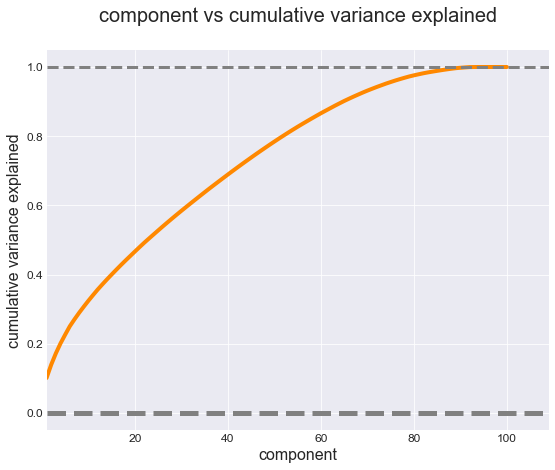

In [170]:
plt.figure(figsize=(9,7))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 101))
plt.plot(component_number, cum_var_exp, lw=4, color='#ff8800')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,109])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

95 principle component captures almost 100% of explained variance

In [171]:
pca = PCA(n_components=95)
pca.fit(trainFS5_scaled)
trainFS5_scaled_pca=pca.transform(trainFS5_scaled)

In [172]:
trainFS5_scaled_pca.shape

(2039, 95)

In [173]:
X_trainFS5pca, X_testFS5pca, y_trainFS5pca, y_testFS5pca=train_test_split(trainFS5_scaled_pca,train_y, random_state=42)



#### Feature Set 3

In [174]:
pca = PCA()
pca_fit = pca.fit(trainFS3_scaled)

print(pca_fit.explained_variance_)
print(pca_fit.components_)

[1.07397608e+01 4.01577065e+00 3.53247033e+00 3.34528740e+00
 2.89325156e+00 2.64601676e+00 2.47245360e+00 2.32163575e+00
 1.94141037e+00 1.86498973e+00 1.75844650e+00 1.65696215e+00
 1.60796479e+00 1.49931517e+00 1.47822621e+00 1.40977884e+00
 1.40717320e+00 1.38331936e+00 1.33098536e+00 1.30596183e+00
 1.28919184e+00 1.27964261e+00 1.25724935e+00 1.24321230e+00
 1.21100586e+00 1.18902228e+00 1.18327335e+00 1.16594629e+00
 1.14459432e+00 1.12814624e+00 1.10548747e+00 1.09810864e+00
 1.08786789e+00 1.07842989e+00 1.07193495e+00 1.05684023e+00
 1.04976809e+00 1.03654006e+00 1.03450048e+00 1.01932466e+00
 1.01418475e+00 1.00400634e+00 9.94949554e-01 9.87944785e-01
 9.76754413e-01 9.73218818e-01 9.52685091e-01 9.38817418e-01
 9.23356781e-01 9.17737860e-01 8.96612462e-01 8.93249810e-01
 8.77955856e-01 8.71444086e-01 8.57510922e-01 8.52367441e-01
 8.20822157e-01 8.09596150e-01 7.92377705e-01 7.73284832e-01
 7.66259144e-01 7.50785879e-01 7.25439524e-01 7.22042816e-01
 7.05979376e-01 6.900152

In [175]:
var_exp = pca_fit.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [1.01268808e-01 3.78660488e-02 3.33088479e-02 3.15438372e-02
 2.72814397e-02 2.49501798e-02 2.33135945e-02 2.18914824e-02
 1.83062097e-02 1.75856139e-02 1.65809820e-02 1.56240520e-02
 1.51620395e-02 1.41375458e-02 1.39386909e-02 1.32932777e-02
 1.32687082e-02 1.30437823e-02 1.25503075e-02 1.23143523e-02
 1.21562224e-02 1.20661795e-02 1.18550259e-02 1.17226659e-02
 1.14189806e-02 1.12116900e-02 1.11574814e-02 1.09940987e-02
 1.07927638e-02 1.06376694e-02 1.04240122e-02 1.03544348e-02
 1.02578713e-02 1.01688773e-02 1.01076343e-02 9.96530108e-03
 9.89861551e-03 9.77388401e-03 9.75465206e-03 9.61155419e-03
 9.56308831e-03 9.46711263e-03 9.38171316e-03 9.31566283e-03
 9.21014507e-03 9.17680675e-03 8.98318736e-03 8.85242442e-03
 8.70664088e-03 8.65365819e-03 8.45445973e-03 8.42275215e-03
 8.27854033e-03 8.21713866e-03 8.08575818e-03 8.03725858e-03
 7.73980751e-03 7.63395372e-03 7.47159523e-03 7.29156212e-03
 7.22531455e-03 7.07941194e-03 6.84041266e-03 6.80838

In [176]:
trainFS3_scaled.shape

(2039, 106)

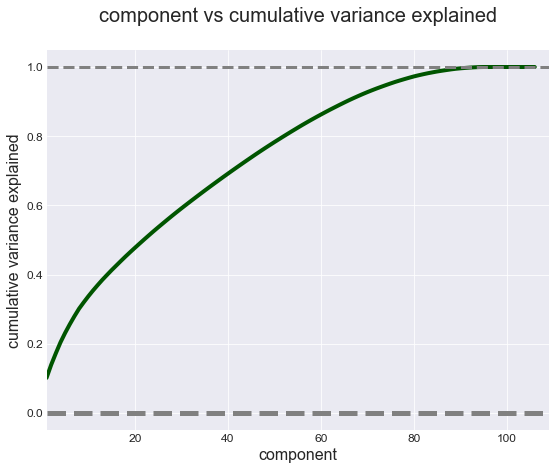

In [177]:
plt.figure(figsize=(9,7))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 107))
plt.plot(component_number, cum_var_exp, lw=4, color='#005500')

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,109])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

100 principle components capture 100% of explain variance  

In [178]:
pca = PCA(n_components=100)
pca.fit(trainFS3_scaled)
trainFS3_scaled_pca=pca.transform(trainFS3_scaled)

In [179]:
X_trainFS3pca, X_testFS3pca, y_trainFS3pca, y_testFS3pca=train_test_split(trainFS3_scaled_pca,train_y, random_state=42)

## Model Building

#### Simple Linear Regression

In [180]:
lr=LinearRegression()
lr.fit(X_trainFS5pca, y_trainFS5pca)
lr.score(X_testFS5pca, y_testFS5pca)

0.8900468804565188

In [181]:
predictLR=lr.predict(X_testFS5pca)
np.sqrt(mean_squared_error(y_testFS5pca, predictLR))

26126.190033829902

In [182]:
r2_score(predictLR,y_testFS5pca )

0.8802721005318217

Trying with feature set 3

In [183]:
lr3=LinearRegression()
lr3.fit(X_trainFS3pca, y_trainFS3pca)
lr3.score(X_testFS3pca, y_testFS3pca)

0.890560555719021

In [184]:
predictLR3=lr3.predict(X_testFS3pca)
np.sqrt(mean_squared_error(y_testFS3pca, predictLR3))

26065.090864855152

In [185]:
r2_score(predictLR3,y_testFS5pca )

0.8807641761612554

#### Ridge Regression

In [186]:
r_alphas=np.logspace(0, 5, 1000)
ridge_model=RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_model=ridge_model.fit(X_trainFS5pca, y_trainFS5pca)


In [187]:
predictRridge_model=ridge_model.predict(X_testFS5pca)
np.sqrt(mean_squared_error(y_testFS5pca, predictRridge_model))

26138.747963043217

In [188]:
r2_score(predictRridge_model,y_testFS5pca )

0.8801297251381861

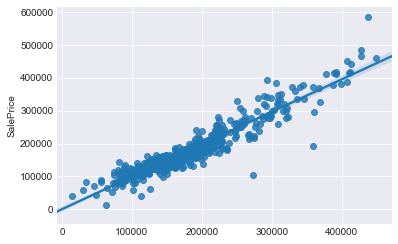

In [189]:
sns.regplot(predictRridge_model,y_testFS5pca )

In [190]:

r_alphas=np.logspace(0, 5, 1000)
ridge_model3=RidgeCV(alphas=r_alphas, store_cv_values=True)
ridge_model3=ridge_model3.fit(X_trainFS3pca, y_trainFS3pca)


In [191]:
predictRridge_model3=ridge_model3.predict(X_testFS3pca)
np.sqrt(mean_squared_error(y_testFS3pca, predictRridge_model3))

25980.512069413195

In [192]:
r2_score(predictRridge_model3,y_testFS3pca )

0.8803660341833885

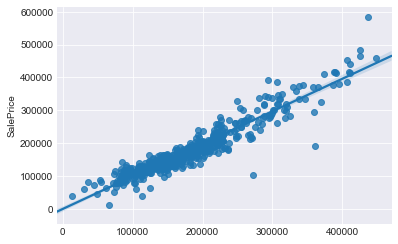

In [193]:
sns.regplot(predictRridge_model3,y_testFS3pca )

#### LASSO Regression Model

In [194]:
l_alphas=np.arange(0.001, 0.050, 0.0025)
lasso_model=LassoCV(alphas=l_alphas, cv=70)
lasso_model.fit(X_trainFS5pca, y_trainFS5pca)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([0.001 , 0.0035, 0.006 , 0.0085, 0.011 , 0.0135, 0.016 , 0.0185,
       0.021 , 0.0235, 0.026 , 0.0285, 0.031 , 0.0335, 0.036 , 0.0385,
       0.041 , 0.0435, 0.046 , 0.0485]),
    copy_X=True, cv=70, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [195]:
predictlasso_model=lasso_model.predict(X_testFS5pca)
np.sqrt(mean_squared_error(y_testFS5pca, predictlasso_model))

26262.32250945447

In [196]:
r2_score(predictlasso_model,y_testFS5pca )

0.879367348768481

### Trying with feature set 3

In [197]:
l_alphas=np.arange(0.001, 0.050, 0.0025)
lasso_model3=LassoCV(alphas=l_alphas, cv=70)
lasso_model3.fit(X_trainFS3pca, y_trainFS3pca)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([0.001 , 0.0035, 0.006 , 0.0085, 0.011 , 0.0135, 0.016 , 0.0185,
       0.021 , 0.0235, 0.026 , 0.0285, 0.031 , 0.0335, 0.036 , 0.0385,
       0.041 , 0.0435, 0.046 , 0.0485]),
    copy_X=True, cv=70, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [198]:
predictlasso_model3=lasso_model3.predict(X_testFS3pca)
np.sqrt(mean_squared_error(y_testFS3pca, predictlasso_model3))

26177.401336652994

In [199]:
r2_score(predictlasso_model3,y_testFS3pca )

0.880032439778469

##  Conclusion

We see Ridge regression with feature set 3 has the best performance. 